
# Tutorial: 10x multiome pbmc


The data consists of *PBMC from a Healthy Donor - Granulocytes Removed Through Cell Sorting (3k)* which is freely available from 10x Genomics (click [here](https://www.10xgenomics.com/resources/datasets/pbmc-from-a-healthy-donor-granulocytes-removed-through-cell-sorting-3-k-1-standard-2-0-0), some personal information needs to be provided before you can gain access to the data). This is a multiome dataset.




Set your working directory below:

In [1]:
import os
path="/Users/merve/Downloads/Tutorials-on-ISMB-2024/hands-on_tutorial/session-3"
if not os.path.exists(path):
    os.makedirs(path)
os.chdir(path)

In [2]:
import pycisTopic
pycisTopic.__version__

'2.0a0'

## Set-up environment and download data 
We will first create a directory to store the data and results

Set-up environment and download data¶
We will first create a directory to store the data and results

In [3]:
import os
os.environ['PATH'] += ':/usr/local/bin'
!mkdir -p data
!wget -O data/fragments.tsv.gz https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz
!wget -O data/fragments.tsv.gz.tbi https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz.tbi
!wget -O data/pbmc_matrix.h5 https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5

--2024-07-02 18:23:41--  https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 467587065 (446M) [text/tab-separated-values]
Saving to: ‘data/fragments.tsv.gz’

data/fragments.tsv. 100%[===================>] 445.92M  62.8MB/s    in 7.1s    

2024-07-02 18:23:49 (63.0 MB/s) - ‘data/fragments.tsv.gz’ saved [467587065/467587065]

--2024-07-02 18:23:49--  https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz.tbi
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 667

Set the temporary and output folders below:

In [4]:
import os
tmp_dir = '/Users/merve/Downloads/Tutorials-on-ISMB-2024/hands-on_tutorial/session-3/tmp'
out_dir = "outs"
os.makedirs(out_dir, exist_ok = True)
os.makedirs(tmp_dir, exist_ok = True)

## scRNA-seq preprocessing using Scanpy
First we preprocess the scRNA-seq side of the mutliome datasets. Most importantly we will use this side of the data to annotate celltypes. 

For this we will make use of [Scanpy](https://scanpy.readthedocs.io/en/stable/). 


<div class="alert alert-info">

**Note:**

You may also use [Seurat](https://satijalab.org/seurat/) (or any other tool in fact) to preprocess your data, however this will require some extra steps to import the data in python.
</div>

<div class="alert alert-info">

**Note:**

Further on in the actual SCENIC+ analysis the raw count matrix will be used.
</div>


In [5]:
import scanpy as sc
#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(5, 5), facecolor='white')

#make a directory for to store the processed scRNA-seq data.
if not os.path.exists(os.path.join(out_dir, 'scRNA')):
    os.makedirs(os.path.join(out_dir, 'scRNA'))

Read in the scRNA-seq count matrix into [AnnData](https://anndata.readthedocs.io/en/latest/) object.

In [6]:
adata = sc.read_10x_h5('data/pbmc_matrix.h5')
adata.var_names_make_unique()
adata

/Users/merve/opt/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2711 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

### Basic quality control
Only keep cells with at least 200 genes expressed and only keep genes which are expressed in at least 3 cells.

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

**Optionally**, predict and filter out doublets using [Scrublet](https://pubmed.ncbi.nlm.nih.gov/30954476/).

In [8]:
sc.external.pp.scrublet(adata) #estimates doublets

/Users/merve/opt/anaconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.24
Detected doublet rate = 2.2%
Estimated detectable doublet fraction = 60.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.7%


In [9]:
adata = adata[adata.obs['predicted_doublet'] == False] #do the actual filtering
adata

View of AnnData object with n_obs × n_vars = 2640 × 21255
    obs: 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'scrublet'

Filter based on mitochondrial counts and total counts.

/var/folders/31/gz4s1kx132l4_hvgmfc1jl2m0000gn/T/ipykernel_42600/3790233708.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


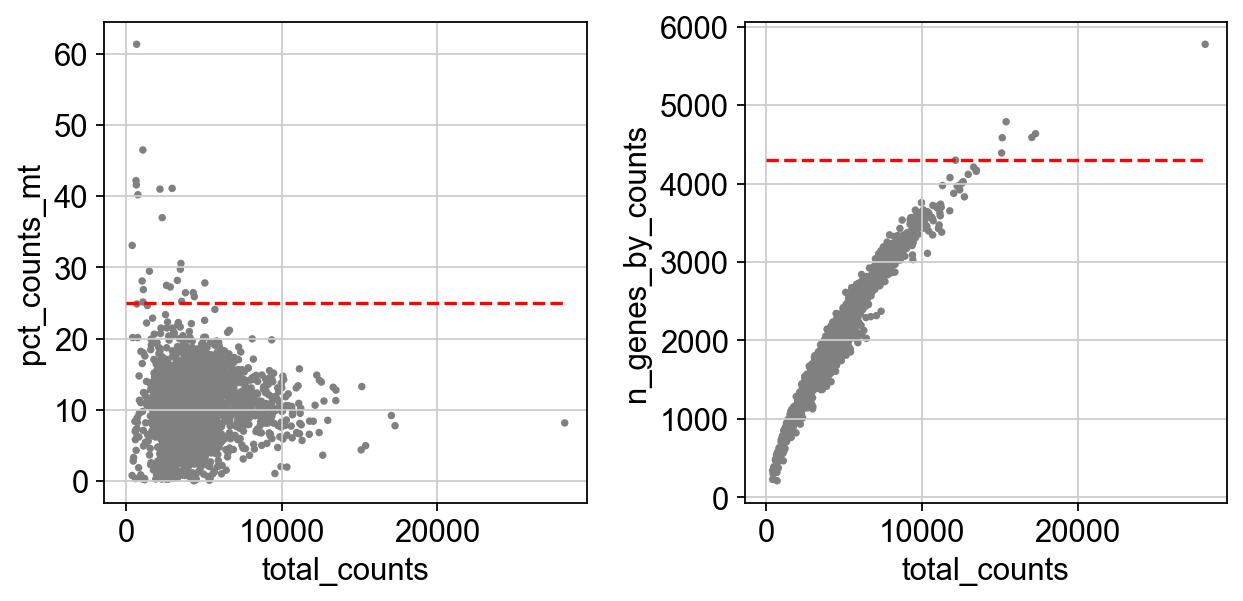

In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
import matplotlib.pyplot as plt
mito_filter = 25
n_counts_filter = 4300
fig, axs = plt.subplots(ncols = 2, figsize = (8,4))
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', ax = axs[0], show=False)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', ax = axs[1], show = False)
#draw horizontal red lines indicating thresholds.
axs[0].hlines(y = mito_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
axs[1].hlines(y = n_counts_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
fig.tight_layout()
plt.show()

In [11]:
adata = adata[adata.obs.n_genes_by_counts < n_counts_filter, :]
adata = adata[adata.obs.pct_counts_mt < mito_filter, :]
adata

View of AnnData object with n_obs × n_vars = 2611 × 21255
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

### Data normalization

<div class="alert alert-info">

**Note:**

Below the data will be normalized and scaled. This is **only** for visualization purposes. For the actual SCENIC+ analysis we will use the raw count matrix. For this reason we save the non-normalized and non-scaled AnnData object in the raw slot before carying on.
</div>

In [12]:
adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

/Users/merve/opt/anaconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


### Cell type annotation

Here we use a pre-annotated dataset as reference (this is actually the processed data from the main scanpy tutorial: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) to transfer labels to unannotated dataset using ingest. 

This is an important step of the preprocessing part because these annotations will be used in pycisTopic to generate pseudobulk ATAC profiles and call peaks.

In [13]:
adata_ref = sc.datasets.pbmc3k_processed() #use the preprocessed data from the Scanpy tutorial as reference
var_names = adata_ref.var_names.intersection(adata.var_names) #use genes which are present in both assays
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]
sc.pp.pca(adata_ref) #calculate PCA embedding
sc.pp.neighbors(adata_ref) #calculate neighborhood graph
sc.tl.umap(adata_ref) #calculate umap embedding
sc.tl.ingest(adata, adata_ref, obs='louvain') #run label transfer
adata.obs.rename({'louvain': 'ingest_celltype_label'}, inplace = True, axis = 1)

/Users/merve/opt/anaconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca
/Users/merve/opt/anaconda3/envs/scenicplus/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/merve/opt/anaconda3/envs/scenicplus/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
<frozen _collections_abc>:949: ImplicitModificationWarning: Setting element `.obsm['rep']` 

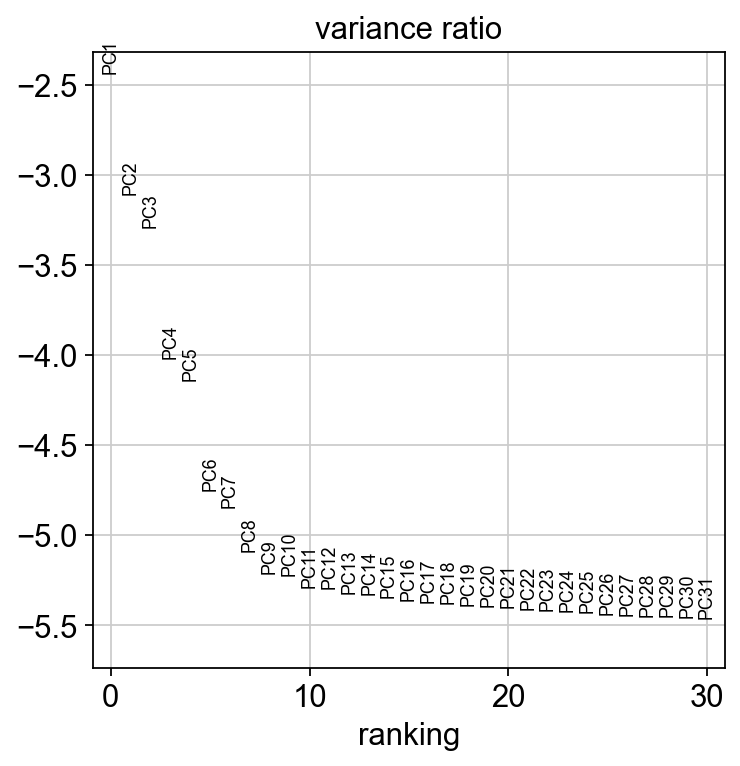

In [14]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

/Users/merve/opt/anaconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


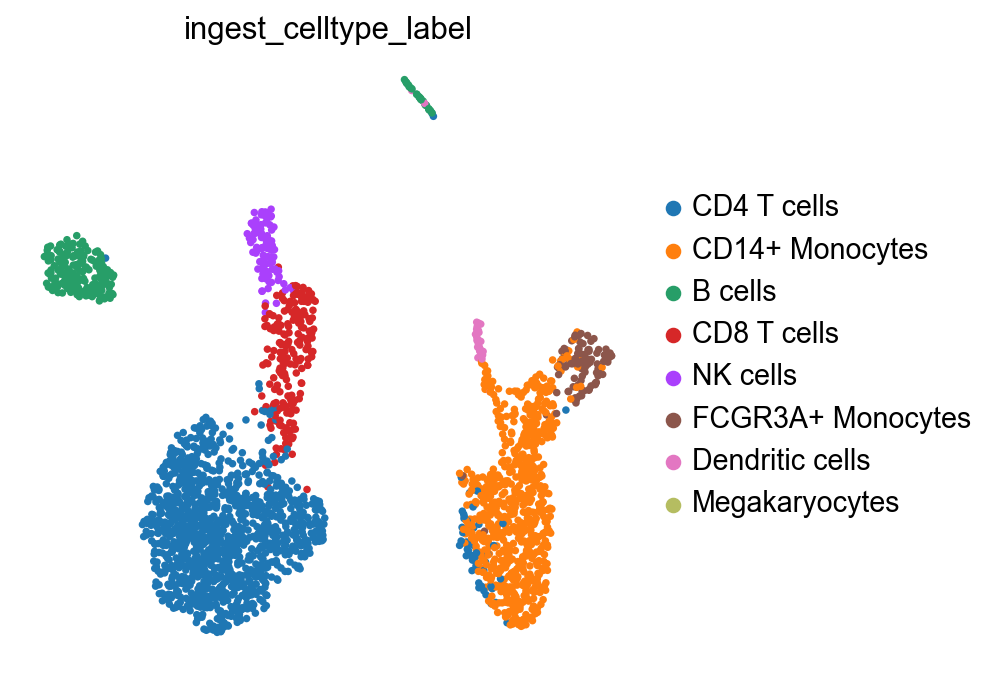

In [15]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color = 'ingest_celltype_label')

We can clean the annotation a bit by finding clusters and then assigning those clusters to cell types based on maximum overlap.

/Users/merve/opt/anaconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


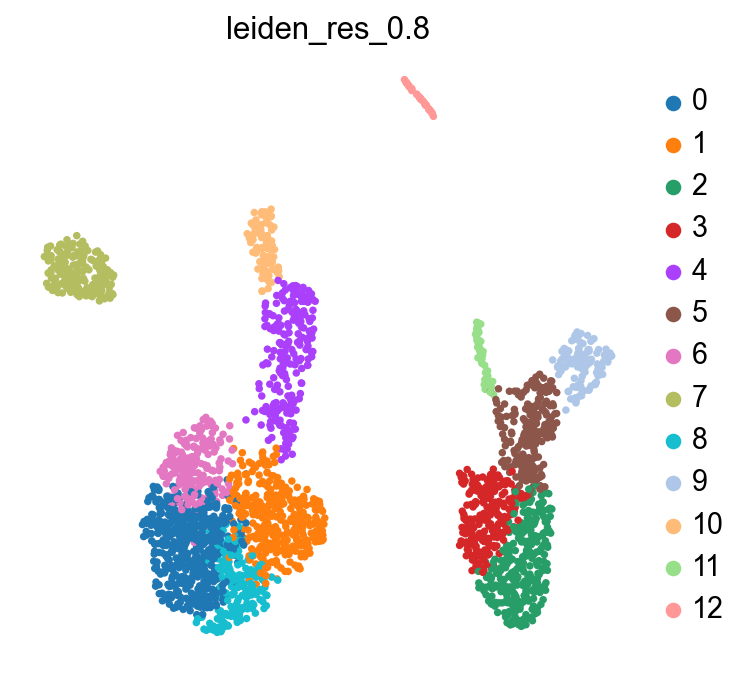

In [16]:
sc.tl.leiden(adata, resolution = 0.8, key_added = 'leiden_res_0.8')
sc.pl.umap(adata, color = 'leiden_res_0.8')

Note, there are two clusters annotated as B cells (cluster 7 and cluster 12). Let's call these cells B cells 1 and B cells 2.

Let's also remove the spaces from the cell type labels.

In [17]:
tmp_df = adata.obs.groupby(['leiden_res_0.8', 'ingest_celltype_label']).size().unstack(fill_value=0)
tmp_df = (tmp_df / tmp_df.sum(0)).fillna(0)
leiden_to_annotation = tmp_df.idxmax(1).to_dict()
leiden_to_annotation

{'0': 'CD4 T cells',
 '1': 'CD4 T cells',
 '2': 'CD14+ Monocytes',
 '3': 'CD14+ Monocytes',
 '4': 'CD8 T cells',
 '5': 'CD14+ Monocytes',
 '6': 'CD4 T cells',
 '7': 'B cells',
 '8': 'CD4 T cells',
 '9': 'FCGR3A+ Monocytes',
 '10': 'NK cells',
 '11': 'Dendritic cells',
 '12': 'B cells'}

In [18]:
leiden_to_annotation['7'] = 'B cells 1'
leiden_to_annotation['12'] = 'B cells 2'
leiden_to_annotation = {cluster: leiden_to_annotation[cluster].replace(' ', '_') for cluster in leiden_to_annotation.keys()}
leiden_to_annotation

{'0': 'CD4_T_cells',
 '1': 'CD4_T_cells',
 '2': 'CD14+_Monocytes',
 '3': 'CD14+_Monocytes',
 '4': 'CD8_T_cells',
 '5': 'CD14+_Monocytes',
 '6': 'CD4_T_cells',
 '7': 'B_cells_1',
 '8': 'CD4_T_cells',
 '9': 'FCGR3A+_Monocytes',
 '10': 'NK_cells',
 '11': 'Dendritic_cells',
 '12': 'B_cells_2'}

In [19]:
adata.obs['celltype'] = [leiden_to_annotation[cluster_id] for cluster_id in adata.obs['leiden_res_0.8']]
del(leiden_to_annotation)
del(tmp_df)

/Users/merve/opt/anaconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


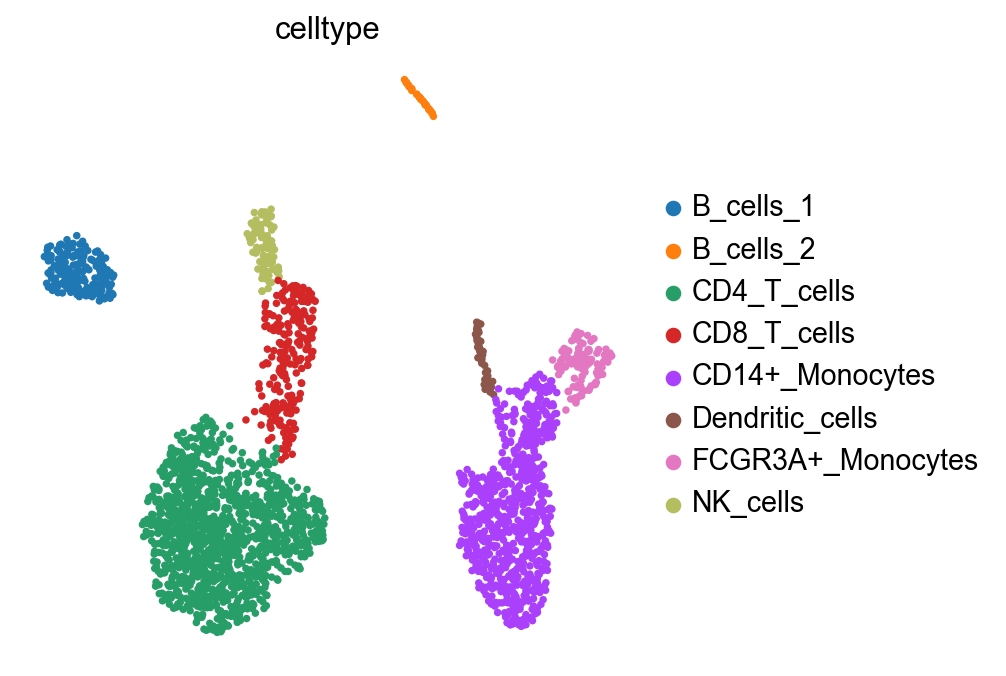

In [20]:
sc.pl.umap(adata, color = 'celltype')

In [21]:
adata.write(os.path.join(out_dir, 'scRNA/adata.h5ad'), compression='gzip')

## scATAC-seq preprocessing using pycisTopic

Now we will preprocess the scATAC-seq data.

Most importantly we will:

1. generate pseudobulk ATAC-seq profiles per cell type and call peaks
2. merge these peaks into a consensus peak-set
3. do quality control on the scATAC-seq barcodes
4. run topic modeling to find sets of co-accessible regions and to impute chromatin accessibility resolving the issue of drop outs

For this we will use the python package [pycisTopic](https://pycistopic.readthedocs.io/en/latest/). 

<div class="alert alert-info">

**Note:**

pycisTopic can also be used for independent analysis of scATAC-seq data and has many more features which will not be demonstrated here. For more information see the read the docs page of [pycisTopic](https://pycistopic.readthedocs.io/en/latest/)
</div>

### Generate pseudobulk ATAC-seq profiles, call peaks and generate a consensus peak set

We will use the cell type labels from the scRNA-seq data to generate pseudobulk profiles per cell type. These pseudobulk profiles will be used to call peaks which will be merged in one consensus peak set.

The advantage of calling peaks per cell type (instead of calling peaks on the whole bulk profile at once) is that, for rare cell types, there is a risk that the ATAC signal of these cells might be confused for noise by the peak caller when viewed in the whole bulk profile. Calling peaks per cell type helps resolving these rare peaks and thus increases the resolution of the data.

We will first load the cell type annotation we generated in the scRNA-seq analysis above.

In [22]:
import scanpy as sc
adata = sc.read_h5ad(os.path.join(out_dir, 'scRNA/adata.h5ad'))
cell_data = adata.obs
cell_data['sample_id'] = '10x_pbmc'
cell_data['celltype'] = cell_data['celltype'].astype(str) # set data type of the celltype column to str, otherwise the export_pseudobulk function will complain.

In [23]:
adata.obs.index = adata.obs.index + '-10x_pbmc'
adata.write(os.path.join(out_dir, 'scRNA/adata.h5ad'), compression='gzip')
del(adata)

Specify the location of the ATAC fragments file, this is the main input into pycisTopic.

In [24]:
fragments_dict = {
    "10x_pbmc": "data/fragments.tsv.gz"
}

In [25]:
import pandas as pd
cell_data

n_genes  doublet_score  predicted_doublet  \
AAACAGCCAAATATCC-1-10x_pbmc     2272       0.007582              False   
AAACAGCCAGGAACTG-1-10x_pbmc     3254       0.022142              False   
AAACAGCCAGGCTTCG-1-10x_pbmc     1798       0.039935              False   
AAACCAACACCTGCTC-1-10x_pbmc     1145       0.023256              False   
AAACCAACAGATTCAT-1-10x_pbmc     1495       0.013229              False   
...                              ...            ...                ...   
TTTGTGGCATCCGTAA-1-10x_pbmc     1346       0.007582              False   
TTTGTGGCATTAGCCA-1-10x_pbmc      972       0.026921              False   
TTTGTGGCATTGCGAC-1-10x_pbmc     2330       0.005080              False   
TTTGTGTTCCGCCTAT-1-10x_pbmc     1057       0.068845              False   
TTTGTGTTCCGTGACA-1-10x_pbmc     1513       0.002517              False   

                             n_genes_by_counts  total_counts  total_counts_mt  \
AAACAGCCAAATATCC-1-10x_pbmc               2271        4746.0            369.0   
AAACAGCCAGGAACTG-1-10x_pbmc               3253        7760.0            693.0   
AAACAGCCAGGCTTCG-1-10x_pbmc               1793        3661.0            409.0   
AAACCAACACCTGCTC-1-10x_pbmc               1142        2159.0            271.0   
AAACCAACAGATTCAT-1-10x_pbmc               1494        2909.0            293.0   
...                                        ...           ...              ...   
TTTGTGGCATCCGTAA-1-10x_pbmc               1343        2560.0            432.0   
TTTGTGGCATTAGCCA-1-10x_pbmc                969        1746.0            191.0   
TTTGTGGCATTGCGAC-1-10x_pbmc               2330        4772.0            316.0   
TTTGTGTTCCGCCTAT-1-10x_pbmc               1056        1913.0            252.0   
TTTGTGTTCCGTGACA-1-10x_pbmc               1513        2759.0            211.0   

                             pct_counts_mt ingest_celltype_label  \
AAACAGCCAAATATCC-1-10x_pbmc       7.774969              NK cells   
AAACAGCCAGGAACTG-1-10x_pbmc       8.930412       CD14+ Monocytes   
AAACAGCCAGGCTTCG-1-10x_pbmc      11.171811       CD14+ Monocytes   
AAACCAACACCTGCTC-1-10x_pbmc      12.552108               B cells   
AAACCAACAGATTCAT-1-10x_pbmc      10.072189              NK cells   
...                                    ...                   ...   
TTTGTGGCATCCGTAA-1-10x_pbmc      16.875000               B cells   
TTTGTGGCATTAGCCA-1-10x_pbmc      10.939290           CD4 T cells   
TTTGTGGCATTGCGAC-1-10x_pbmc       6.621961              NK cells   
TTTGTGTTCCGCCTAT-1-10x_pbmc      13.173027           CD4 T cells   
TTTGTGTTCCGTGACA-1-10x_pbmc       7.647698              NK cells   

                            leiden_res_0.8         celltype sample_id  
AAACAGCCAAATATCC-1-10x_pbmc             10         NK_cells  10x_pbmc  
AAACAGCCAGGAACTG-1-10x_pbmc              5  CD14+_Monocytes  10x_pbmc  
AAACAGCCAGGCTTCG-1-10x_pbmc              2  CD14+_Monocytes  10x_pbmc  
AAACCAACACCTGCTC-1-10x_pbmc              7        B_cells_1  10x_pbmc  
AAACCAACAGATTCAT-1-10x_pbmc              4      CD8_T_cells  10x_pbmc  
...                                    ...              ...       ...  
TTTGTGGCATCCGTAA-1-10x_pbmc              7        B_cells_1  10x_pbmc  
TTTGTGGCATTAGCCA-1-10x_pbmc              0      CD4_T_cells  10x_pbmc  
TTTGTGGCATTGCGAC-1-10x_pbmc             10         NK_cells  10x_pbmc  
TTTGTGTTCCGCCTAT-1-10x_pbmc              0      CD4_T_cells  10x_pbmc  
TTTGTGTTCCGTGACA-1-10x_pbmc             10         NK_cells  10x_pbmc  

[2611 rows x 11 columns]

Next, we will generate the pseudobulk profiles. 

This will generate two sets of files:

1. pseudobulk_bed_files: pseudobulk profiles stored in [bed format](https://genome.ucsc.edu/FAQ/FAQformat.html).
2. pseudobulk_bw_files: pseudobulk profiles stored in [BigWig format](https://genome.ucsc.edu/goldenpath/help/bigWig.html).

The BigWig files are useful for visualization in [IGV](https://software.broadinstitute.org/software/igv/) or [UCSC genome browser](https://genome.ucsc.edu/).


In [26]:
chromsizes = pd.read_table(
    "http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes",
    header = None,
    names = ["Chromosome", "End"]
)
chromsizes.insert(1, "Start", 0)
chromsizes

Chromosome  Start        End
0                chr1      0  248956422
1                chr2      0  242193529
2                chr3      0  198295559
3                chr4      0  190214555
4                chr5      0  181538259
..                ...    ...        ...
450  chrUn_KI270539v1      0        993
451  chrUn_KI270385v1      0        990
452  chrUn_KI270423v1      0        981
453  chrUn_KI270392v1      0        971
454  chrUn_KI270394v1      0        970

[455 rows x 3 columns]

In [27]:
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
os.makedirs(os.path.join(out_dir, "consensus_peak_calling"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bed_files"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bw_files"), exist_ok = True)


bw_paths, bed_paths = export_pseudobulk(
    input_data = cell_data,
    variable = "celltype",
    sample_id_col = "sample_id",
    chromsizes = chromsizes,
    bed_path = os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bed_files"),
    bigwig_path = os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bw_files"),
    path_to_fragments = fragments_dict,
    n_cpu = 1,
    normalize_bigwig = True,
    temp_dir = tmp_dir,
    split_pattern = "-"
)

2024-07-02 18:24:53,681	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


2024-07-02 18:24:54,189 cisTopic     INFO     Splitting fragments by cell type.
2024-07-02 18:26:00,352 cisTopic     INFO     generating bigwig files
2024-07-02 18:26:11,903 cisTopic     INFO     outs/consensus_peak_calling/pseudobulk_bw_files/NK_cells.bw done!
2024-07-02 18:26:39,524 cisTopic     INFO     outs/consensus_peak_calling/pseudobulk_bw_files/CD14+_Monocytes.bw done!
2024-07-02 18:26:52,663 cisTopic     INFO     outs/consensus_peak_calling/pseudobulk_bw_files/B_cells_1.bw done!
2024-07-02 18:27:05,572 cisTopic     INFO     outs/consensus_peak_calling/pseudobulk_bw_files/CD8_T_cells.bw done!
2024-07-02 18:27:36,284 cisTopic     INFO     outs/consensus_peak_calling/pseudobulk_bw_files/CD4_T_cells.bw done!
2024-07-02 18:27:48,548 cisTopic     INFO     outs/consensus_peak_calling/pseudobulk_bw_files/FCGR3A+_Monocytes.bw done!
2024-07-02 18:27:57,768 cisTopic     INFO     outs/consensus_peak_calling/pseudobulk_bw_files/B_cells_2.bw done!
2024-07-02 18:28:08,037 cisTopic     INFO 

Save the paths to bed and bigwig files for later access:

In [28]:
with open(os.path.join(out_dir, "consensus_peak_calling/bw_paths.tsv"), "wt") as f:
    for v in bw_paths:
        _ = f.write(f"{v}\t{bw_paths[v]}\n")

In [29]:
with open(os.path.join(out_dir, "consensus_peak_calling/bed_paths.tsv"), "wt") as f:
    for v in bed_paths:
        _ = f.write(f"{v}\t{bed_paths[v]}\n")

In [30]:
bw_paths = {}
with open(os.path.join(out_dir, "consensus_peak_calling/bw_paths.tsv")) as f:
    for line in f:
        v, p = line.strip().split("\t")
        bw_paths.update({v: p})

In [31]:
bed_paths = {}
with open(os.path.join(out_dir, "consensus_peak_calling/bed_paths.tsv")) as f:
    for line in f:
        v, p = line.strip().split("\t")
        bed_paths.update({v: p})

Call peaks per pseudobulk profile:

In [32]:
from pycisTopic.pseudobulk_peak_calling import peak_calling
macs_path = "macs2"

os.makedirs(os.path.join(out_dir, "consensus_peak_calling/MACS"), exist_ok = True)

narrow_peak_dict = peak_calling(
    macs_path = macs_path,
    bed_paths = bed_paths,
    outdir = os.path.join(os.path.join(out_dir, "consensus_peak_calling/MACS")),
    genome_size = 'hs',
    input_format = 'BEDPE',
    shift = 73,
    ext_size = 146,
    keep_dup = 'all',
    q_value = 0.05,
    _temp_dir = os.path.join(tmp_dir, 'ray_spill'))

2024-07-02 18:28:08,063 cisTopic     INFO     Calling peaks for NK_cells with macs2 callpeak --treatment outs/consensus_peak_calling/pseudobulk_bed_files/NK_cells.fragments.tsv.gz --name NK_cells  --outdir outs/consensus_peak_calling/MACS --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
2024-07-02 18:28:21,177 cisTopic     INFO     NK_cells done!
2024-07-02 18:28:21,178 cisTopic     INFO     Calling peaks for CD14+_Monocytes with macs2 callpeak --treatment outs/consensus_peak_calling/pseudobulk_bed_files/CD14+_Monocytes.fragments.tsv.gz --name CD14+_Monocytes  --outdir outs/consensus_peak_calling/MACS --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
2024-07-02 18:29:14,007 cisTopic     INFO     CD14+_Monocytes done!
2024-07-02 18:29:14,008 cisTopic     INFO     Calling peaks for B_cells_1 with macs2 callpeak --treatment outs/consensus_peak_calling/pseudo

Blacklist regions for different species can be downloaded from [github](https://github.com/aertslab/pycisTopic/tree/main/blacklist). Specify the path below!

Merge peaks into consensus peak set (for more info, please see [pyCistopic read the docs](https://pycistopic.readthedocs.io/en/latest/)):

In [33]:
from pycisTopic.iterative_peak_calling import get_consensus_peaks
# Other param
peak_half_width=250
path_to_blacklist='/Users/merve/Downloads/hg38-blacklist.v2.bed'

# Get consensus peaks
consensus_peaks = get_consensus_peaks(
    narrow_peaks_dict = narrow_peak_dict,
    peak_half_width = peak_half_width,
    chromsizes = chromsizes,
    path_to_blacklist = path_to_blacklist)

2024-07-02 18:31:29,656 cisTopic     INFO     Extending and merging peaks per class
2024-07-02 18:31:55,420 cisTopic     INFO     Normalizing peak scores
2024-07-02 18:31:55,656 cisTopic     INFO     Merging peaks
Warning! Start and End columns now have different dtypes: int64 and int32
2024-07-02 18:32:26,128 cisTopic     INFO     Done!


In [34]:
consensus_peaks.to_bed(
    path = os.path.join(out_dir, "consensus_peak_calling/consensus_regions.bed"),
    keep =True,
    compression = 'infer',
    chain = False)

/Users/merve/opt/anaconda3/envs/scenicplus/lib/python3.11/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/Users/merve/opt/anaconda3/envs/scenicplus/lib/python3.11/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/Users/merve/opt/anaconda3/envs/scenicplus/lib/python3.11/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/Users/merve/opt/anaconda3/envs/scenicplus/lib/python3.11/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  retu

### Quality control

Next we will calculate sample level and cell-barcode level quality control statistics.

Barcode level QC stats include:

1. Log number of unique fragments per cell barcode.
2. FRIP per cell barcode.
3. TSS enrichment per cell barcode.
4. Duplication rate per cell barcode.

In [35]:
!pycistopic tss gene_annotation_list | grep Human


hsapiens_gene_ensembl	Human genes (GRCh38.p14)


In [36]:
!mkdir -p outs/qc
!pycistopic tss get_tss \
    --output outs/qc/tss.bed \
    --name "hsapiens_gene_ensembl" \
    --to-chrom-source ucsc \
    --ucsc hg38

- Get TSS annotation from Ensembl BioMart with the following settings:
  - biomart_name: "hsapiens_gene_ensembl"
  - biomart_host: "http://www.ensembl.org"
  - transcript_type: ['protein_coding']
  - use_cache: True
- Getting chromosome sizes and alias mapping for "hg38" from UCSC.
- Update chromosome names in TSS annotation to "ucsc" chromosome names.
- Writing TSS annotation BED file to "outs/qc/tss.bed".


In [37]:
!head outs/qc/tss.bed | column -t


#     Chromosome  Start  End      Gene  Score  Strand          Transcript_type
chrM  3306        3307   MT-ND1   .     +      protein_coding
chrM  4469        4470   MT-ND2   .     +      protein_coding
chrM  5903        5904   MT-CO1   .     +      protein_coding
chrM  7585        7586   MT-CO2   .     +      protein_coding
chrM  8365        8366   MT-ATP8  .     +      protein_coding
chrM  8526        8527   MT-ATP6  .     +      protein_coding
chrM  9206        9207   MT-CO3   .     +      protein_coding
chrM  10058       10059  MT-ND3   .     +      protein_coding
chrM  10469       10470  MT-ND4L  .     +      protein_coding


In [38]:
!pycistopic qc \
    --fragments data/fragments.tsv.gz \
    --regions outs/consensus_peak_calling/consensus_regions.bed \
    --tss outs/qc/tss.bed \
    --output outs/qc/10x_pbmc

In [39]:
regions_bed_filename = os.path.join(out_dir, "consensus_peak_calling/consensus_regions.bed")
tss_bed_filename = os.path.join(out_dir, "qc", "tss.bed")

pycistopic_qc_commands_filename = "pycistopic_qc_commands.txt"

# Create text file with all pycistopic qc command lines.
with open(pycistopic_qc_commands_filename, "w") as fh:
    for sample, fragment_filename in fragments_dict.items():
        print(
            "pycistopic qc",
            f"--fragments {fragment_filename}",
            f"--regions {regions_bed_filename}",
            f"--tss {tss_bed_filename}",
            f"--output {os.path.join(out_dir, 'qc')}/{sample}",
            sep=" ",
            file=fh,
        )

You can install `parallel` using brew:

#brew install parallel

In [40]:
import os
os.environ['PATH'] += ':/usr/local/bin'
!cat pycistopic_qc_commands.txt | parallel -j 4 {}

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2024, June 22). GNU Parallel 20240622 ('34 counts').
  Zenodo. https://doi.org/10.5281/zenodo.12518196

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.



We can also visualize barcode level statistics.

These statistics can be used to filter cell barcodes to retain only high quality cells.



/Users/merve/opt/anaconda3/envs/scenicplus/lib/python3.11/site-packages/pycisTopic/plotting/qc_plot.py:226: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


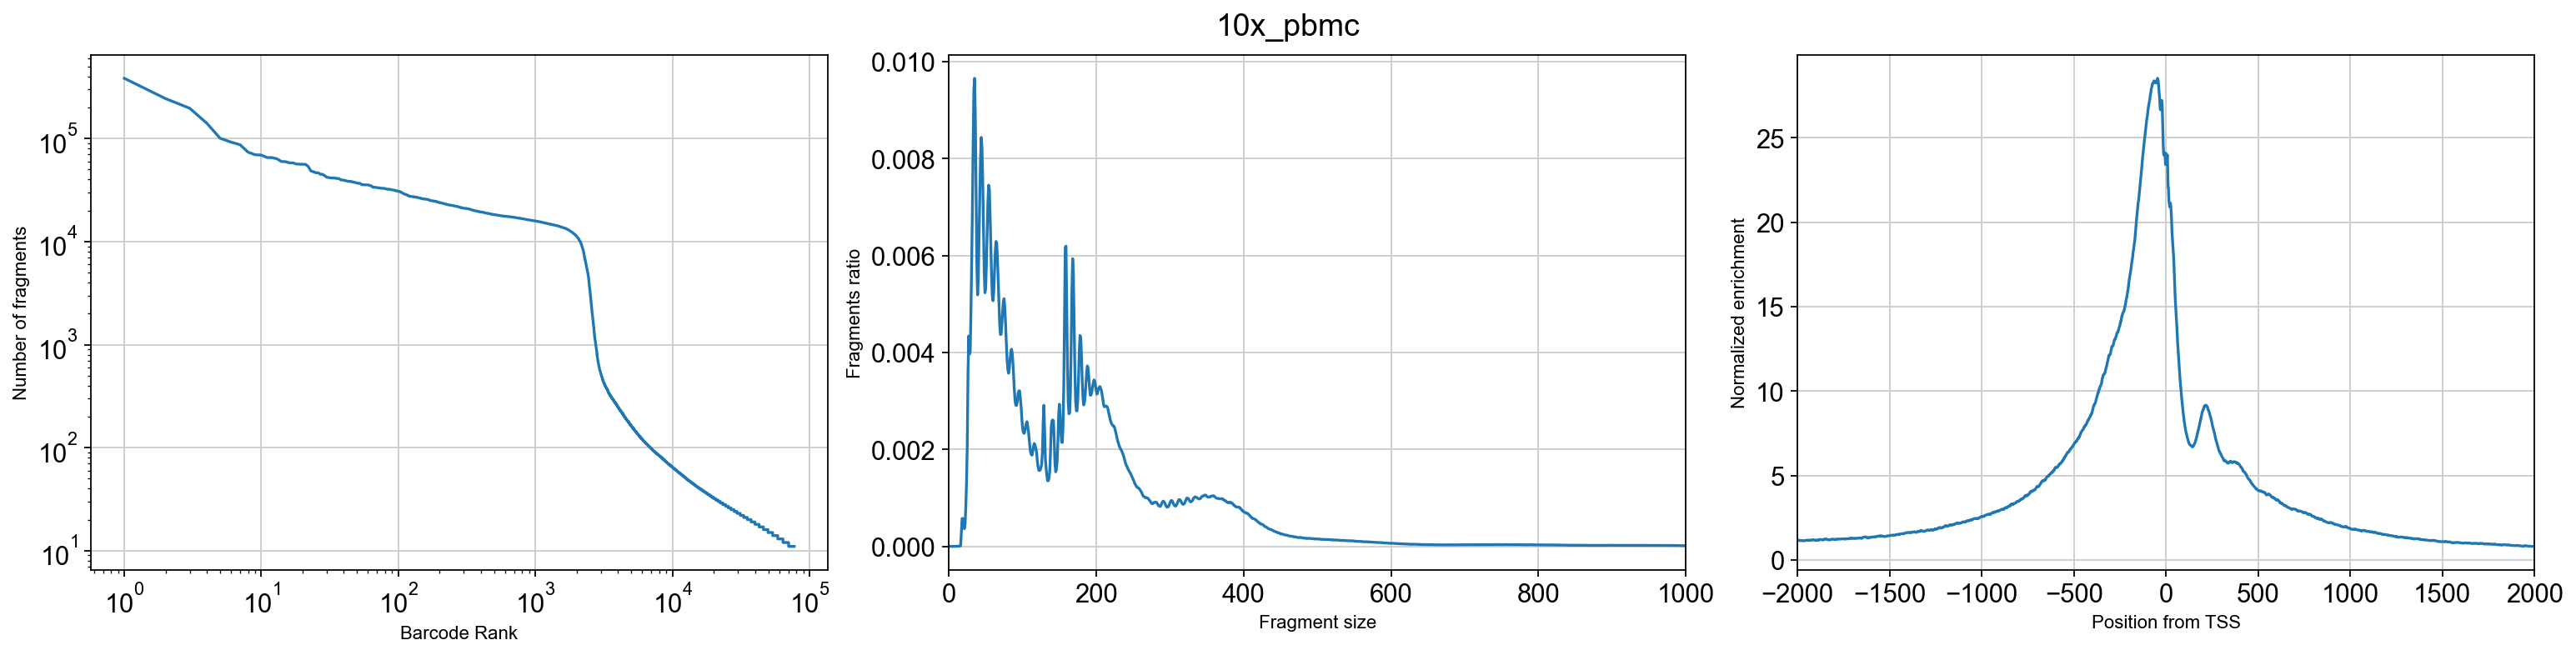

In [41]:
from pycisTopic.plotting.qc_plot import plot_sample_stats, plot_barcode_stats
import matplotlib.pyplot as plt
for sample_id in fragments_dict:
    fig = plot_sample_stats(
        sample_id = sample_id,
        pycistopic_qc_output_dir = "outs/qc"
    )

Filter cell barcodes:

In [42]:
from pycisTopic.qc import get_barcodes_passing_qc_for_sample
sample_id_to_barcodes_passing_filters = {}
sample_id_to_thresholds = {}
for sample_id in fragments_dict:
    (
        sample_id_to_barcodes_passing_filters[sample_id],
        sample_id_to_thresholds[sample_id]
    ) = get_barcodes_passing_qc_for_sample(
            sample_id = sample_id,
            pycistopic_qc_output_dir = "outs/qc",
            unique_fragments_threshold = None, # use automatic thresholding
            tss_enrichment_threshold = None, # use automatic thresholding
            frip_threshold = 0,
            use_automatic_thresholds = True,
    )

10x_pbmc:
	Using automatic threshold for unique fragments: 1310.8610184476847
	Using automatic threshold for TSS enrichment: 13.077763074075694


/Users/merve/opt/anaconda3/envs/scenicplus/lib/python3.11/site-packages/pycisTopic/plotting/qc_plot.py:446: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


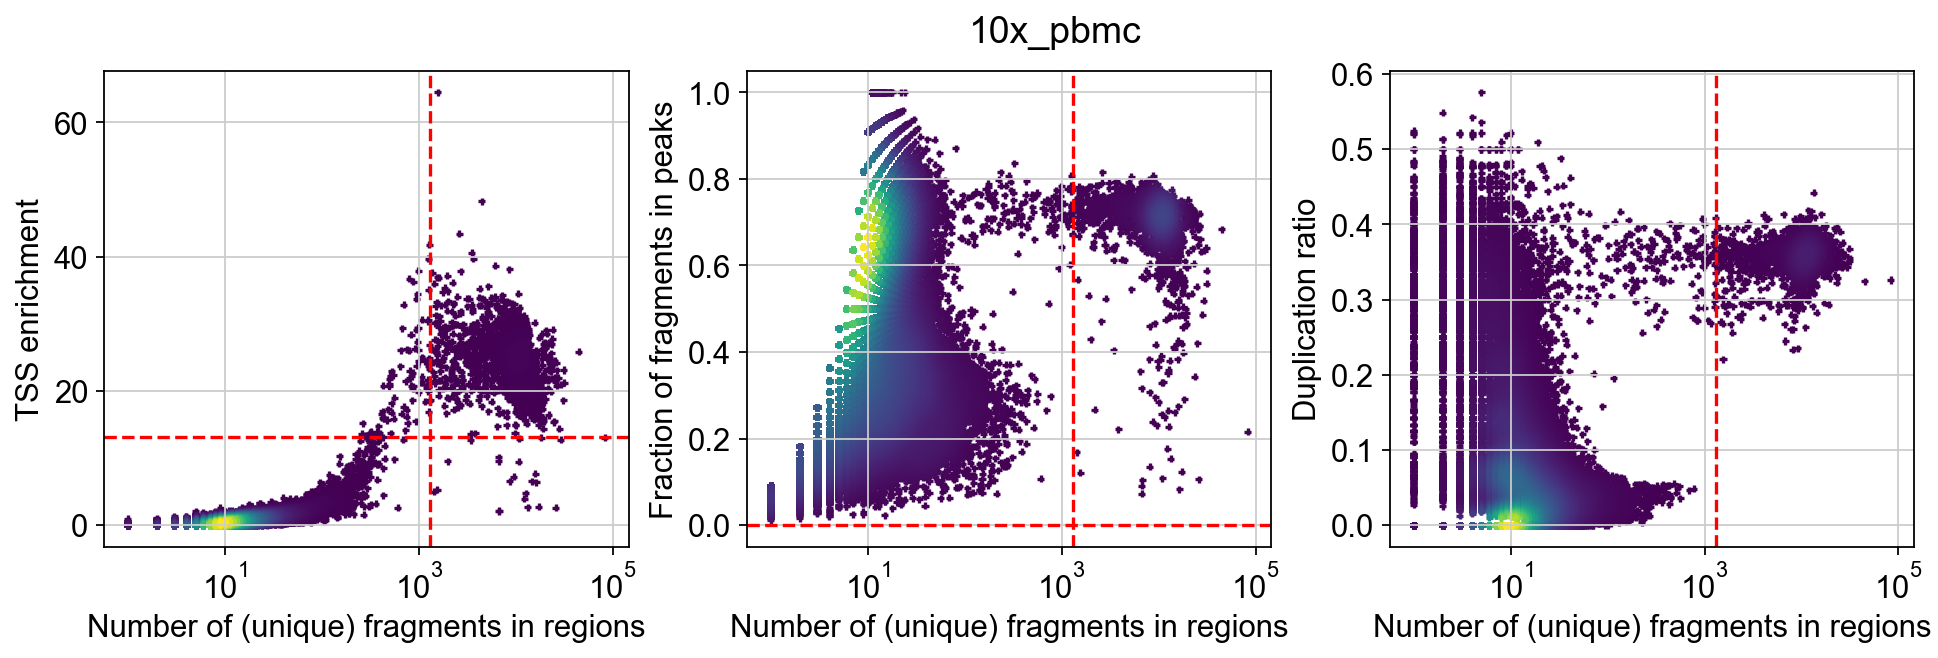

In [43]:
for sample_id in fragments_dict:
    fig = plot_barcode_stats(
        sample_id = sample_id,
        pycistopic_qc_output_dir = "outs/qc",
        bc_passing_filters = sample_id_to_barcodes_passing_filters[sample_id],
        detailed_title = False,
        **sample_id_to_thresholds[sample_id]
    )

### Creating a cisTopic object and topic modeling

Now that we have good quality barcodes, we will generate a binary count matrix of ATAC-seq fragments over consensus peaks. This matrix, along with metadata, will be stored in a cisTopic object and be used for topic modeling.

We will start by reading cell metadata from the scRNA-seq side of the analysis. For SCENIC+, we will only keep cells which passed quality metrics in both assays.

<div class="alert alert-info">

**Note:**

For independent scATAC-seq analysis you probably want to keep all cells (not only the cells passing the scRNA-seq filters). 
</div>

In [44]:
path_to_regions = os.path.join(out_dir, "consensus_peak_calling/consensus_regions.bed")
path_to_blacklist = "/Users/merve/Downloads/hg38-blacklist.v2.bed"
pycistopic_qc_output_dir = path+"/outs/qc"

In [45]:
from pycisTopic.cistopic_class import create_cistopic_object_from_fragments
import polars as pl

cistopic_obj_list = []
for sample_id in fragments_dict:
    sample_metrics = pl.read_parquet(
        os.path.join(pycistopic_qc_output_dir, f'{sample_id}.fragments_stats_per_cb.parquet')
    ).to_pandas().set_index("CB").loc[ sample_id_to_barcodes_passing_filters[sample_id] ]
    cistopic_obj = create_cistopic_object_from_fragments(
        path_to_fragments = fragments_dict[sample_id],
        path_to_regions = path_to_regions,
        path_to_blacklist = path_to_blacklist,
        metrics = sample_metrics,
        valid_bc = sample_id_to_barcodes_passing_filters[sample_id],
        n_cpu = 1,
        project = sample_id,
        split_pattern = '-'
    )
    cistopic_obj_list.append(cistopic_obj)

2024-07-02 18:48:08,977 cisTopic     INFO     Reading data for 10x_pbmc
2024-07-02 18:48:39,608 cisTopic     INFO     metrics provided!
2024-07-02 18:48:42,088 cisTopic     INFO     Counting fragments in regions
2024-07-02 18:48:57,353 cisTopic     INFO     Creating fragment matrix
2024-07-02 18:49:13,626 cisTopic     INFO     Converting fragment matrix to sparse matrix
2024-07-02 18:49:16,050 cisTopic     INFO     Removing blacklisted regions
2024-07-02 18:49:16,697 cisTopic     INFO     Creating CistopicObject
2024-07-02 18:49:17,305 cisTopic     INFO     Done!


In [46]:
cistopic_obj = cistopic_obj_list[0]
print(cistopic_obj)

CistopicObject from project 10x_pbmc with n_cells × n_regions = 2572 × 193712


In [47]:
import pickle
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)

## Adding metadata to a cisTopic object

We can add additional metadata (for regions or cells) to a cisTopic object. For example, let’s add the scRNA-seq data annotations. Missing values will be filled with `Nan`.

In [48]:
import pandas as pd
cell_data.head()

n_genes  doublet_score  predicted_doublet  \
AAACAGCCAAATATCC-1-10x_pbmc     2272       0.007582              False   
AAACAGCCAGGAACTG-1-10x_pbmc     3254       0.022142              False   
AAACAGCCAGGCTTCG-1-10x_pbmc     1798       0.039935              False   
AAACCAACACCTGCTC-1-10x_pbmc     1145       0.023256              False   
AAACCAACAGATTCAT-1-10x_pbmc     1495       0.013229              False   

                             n_genes_by_counts  total_counts  total_counts_mt  \
AAACAGCCAAATATCC-1-10x_pbmc               2271        4746.0            369.0   
AAACAGCCAGGAACTG-1-10x_pbmc               3253        7760.0            693.0   
AAACAGCCAGGCTTCG-1-10x_pbmc               1793        3661.0            409.0   
AAACCAACACCTGCTC-1-10x_pbmc               1142        2159.0            271.0   
AAACCAACAGATTCAT-1-10x_pbmc               1494        2909.0            293.0   

                             pct_counts_mt ingest_celltype_label  \
AAACAGCCAAATATCC-1-10x_pbmc       7.774969              NK cells   
AAACAGCCAGGAACTG-1-10x_pbmc       8.930412       CD14+ Monocytes   
AAACAGCCAGGCTTCG-1-10x_pbmc      11.171811       CD14+ Monocytes   
AAACCAACACCTGCTC-1-10x_pbmc      12.552108               B cells   
AAACCAACAGATTCAT-1-10x_pbmc      10.072189              NK cells   

                            leiden_res_0.8         celltype sample_id  
AAACAGCCAAATATCC-1-10x_pbmc             10         NK_cells  10x_pbmc  
AAACAGCCAGGAACTG-1-10x_pbmc              5  CD14+_Monocytes  10x_pbmc  
AAACAGCCAGGCTTCG-1-10x_pbmc              2  CD14+_Monocytes  10x_pbmc  
AAACCAACACCTGCTC-1-10x_pbmc              7        B_cells_1  10x_pbmc  
AAACCAACAGATTCAT-1-10x_pbmc              4      CD8_T_cells  10x_pbmc

In [49]:
cistopic_obj.add_cell_data(cell_data, split_pattern='-')
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)


Columns ['sample_id'] will be overwritten


In [50]:
cistopic_obj.cell_data


log10_total_fragments_count  \
ATAGGTACACTGGCCA-1-10x_pbmc                     4.434760   
TGCTCCGTCAGCTAAC-1-10x_pbmc                     4.639277   
ATGGCTAGTGTGAGAG-1-10x_pbmc                     4.316620   
AAACCGCGTGAGGTAG-1-10x_pbmc                     4.697290   
GAAGGCTAGAACAAGT-1-10x_pbmc                     4.289187   
...                                                  ...   
GAAACTGAGCTAGAAG-1-10x_pbmc                     3.789933   
GATTGGCGTGTTAGCA-1-10x_pbmc                     3.487421   
TCGCGAGGTATTGGTG-1-10x_pbmc                     3.732715   
AGCCTGGGTAACCAGC-1-10x_pbmc                     3.703635   
CAAATCATCAGCAAGA-1-10x_pbmc                     3.517328   

                             pdf_values_for_tss_enrichment  barcode_rank  \
ATAGGTACACTGGCCA-1-10x_pbmc                       0.004925           522   
TGCTCCGTCAGCTAAC-1-10x_pbmc                       0.002522           119   
ATGGCTAGTGTGAGAG-1-10x_pbmc                       0.009722          1302   
AAACCGCGTGAGGTAG-1-10x_pbmc                       0.000590           105   
GAAGGCTAGAACAAGT-1-10x_pbmc                       0.008704          1597   
...                                                    ...           ...   
GAAACTGAGCTAGAAG-1-10x_pbmc                       0.000092          2465   
GATTGGCGTGTTAGCA-1-10x_pbmc                       0.000123          2604   
TCGCGAGGTATTGGTG-1-10x_pbmc                       0.000626          2479   
AGCCTGGGTAACCAGC-1-10x_pbmc                       0.000455          2508   
CAAATCATCAGCAAGA-1-10x_pbmc                       0.000325          2569   

                             tss_enrichment  unique_fragments_count  \
ATAGGTACACTGGCCA-1-10x_pbmc       20.850410                   18097   
TGCTCCGTCAGCTAAC-1-10x_pbmc       19.195438                   27711   
ATGGCTAGTGTGAGAG-1-10x_pbmc       25.376703                   14704   
AAACCGCGTGAGGTAG-1-10x_pbmc       25.112861                   30141   
GAAGGCTAGAACAAGT-1-10x_pbmc       23.683289                   13637   
...                                     ...                     ...   
GAAACTGAGCTAGAAG-1-10x_pbmc       37.826729                    3920   
GATTGGCGTGTTAGCA-1-10x_pbmc       35.934521                    1933   
TCGCGAGGTATTGGTG-1-10x_pbmc       25.456869                    3646   
AGCCTGGGTAACCAGC-1-10x_pbmc       23.566926                    3195   
CAAATCATCAGCAAGA-1-10x_pbmc       29.409955                    2326   

                             unique_fragments_in_peaks_count cisTopic_nr_acc  \
ATAGGTACACTGGCCA-1-10x_pbmc                             9903            8751   
TGCTCCGTCAGCTAAC-1-10x_pbmc                            14003           11614   
ATGGCTAGTGTGAGAG-1-10x_pbmc                            10216            8448   
AAACCGCGTGAGGTAG-1-10x_pbmc                            22082           16092   
GAAGGCTAGAACAAGT-1-10x_pbmc                             9518            7993   
...                                                      ...             ...   
GAAACTGAGCTAGAAG-1-10x_pbmc                             2709            2664   
GATTGGCGTGTTAGCA-1-10x_pbmc                             1445            1418   
TCGCGAGGTATTGGTG-1-10x_pbmc                             2592            2526   
AGCCTGGGTAACCAGC-1-10x_pbmc                             2385            2292   
CAAATCATCAGCAAGA-1-10x_pbmc                             1778            1769   

                             duplication_ratio cisTopic_nr_frag  \
ATAGGTACACTGGCCA-1-10x_pbmc           0.334938            10253   
TGCTCCGTCAGCTAAC-1-10x_pbmc           0.364106            14476   
ATGGCTAGTGTGAGAG-1-10x_pbmc           0.290690            10574   
AAACCGCGTGAGGTAG-1-10x_pbmc           0.394832            22830   
GAAGGCTAGAACAAGT-1-10x_pbmc           0.299265             9871   
...                                        ...              ...   
GAAACTGAGCTAGAAG-1-10x_pbmc           0.364049             2796   
GATTGGCGTGTTAGCA-1-10x_pbmc           0.37056

## Running scrublet

Optionally, you can run also scrublet on the fragment count matrix to infer doublets from the scATAC-seq.

Preprocessing...


/Users/merve/opt/anaconda3/envs/scenicplus/lib/python3.11/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.39
Detected doublet rate = 3.3%
Estimated detectable doublet fraction = 58.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.7%
Elapsed time: 7.6 seconds
Detected doublet rate = 12.6%
Estimated detectable doublet fraction = 72.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 17.3%


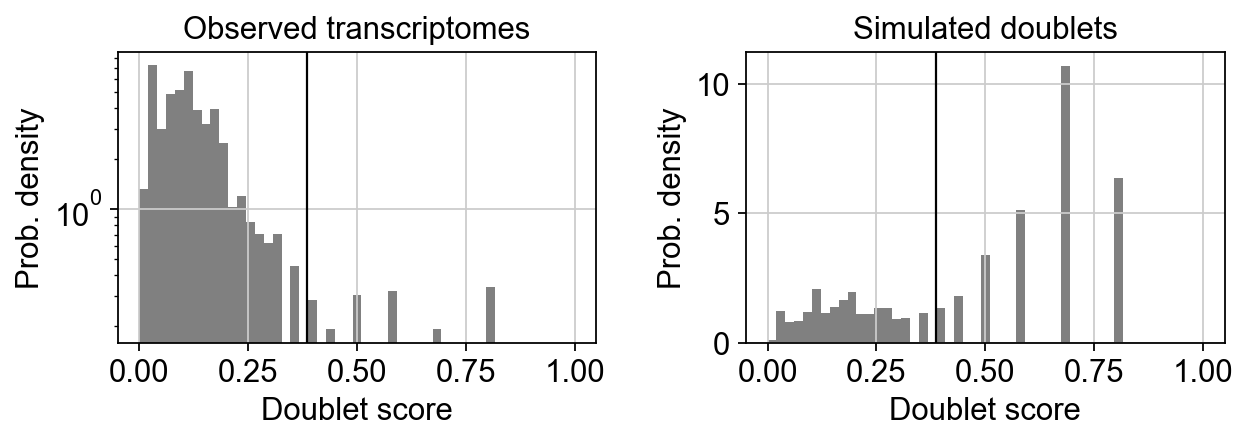

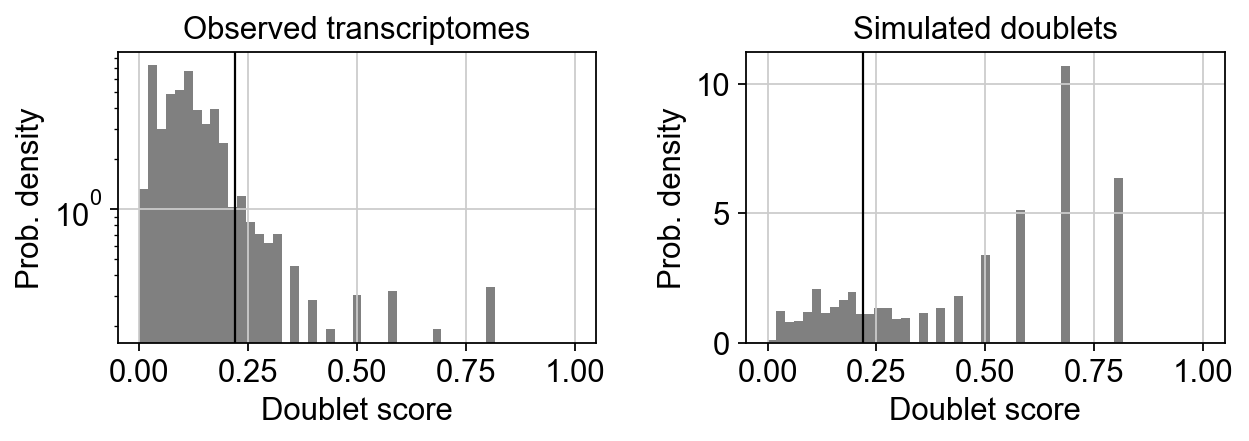

In [51]:
import scrublet as scr
scrub = scr.Scrublet(cistopic_obj.fragment_matrix.T, expected_doublet_rate=0.1)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
scrub.plot_histogram();
scrub.call_doublets(threshold=0.22)
scrub.plot_histogram();
scrublet = pd.DataFrame([scrub.doublet_scores_obs_, scrub.predicted_doublets_], columns=cistopic_obj.cell_names, index=['Doublet_scores_fragments', 'Predicted_doublets_fragments']).T

In [52]:
cistopic_obj.add_cell_data(scrublet, split_pattern = '-')
sum(cistopic_obj.cell_data.Predicted_doublets_fragments == True)

324

In [53]:
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)
# Remove doublets
singlets = cistopic_obj.cell_data[cistopic_obj.cell_data.Predicted_doublets_fragments == False].index.tolist()
# Subset cisTopic object
cistopic_obj_noDBL = cistopic_obj.subset(singlets, copy=True, split_pattern='-')
print(cistopic_obj_noDBL)

CistopicObject from project 10x_pbmc with n_cells × n_regions = 2248 × 193704


In [54]:
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)

## Run models

Next, we will perform the actual topic modeling using LDA using a Collapsed Gibbs Sampler.

There are two functions that can be used to perform the topic modeling, both produce similar results.

- **Serial LDA**: The parallelization is done between models rather than within each model and recommended for small-medium sized data sets in which several models with different numbers of topics are being tested. You can run these models with runCGSModels().
- **Parallel LDA with MALLET**: The parallelization is done within each model and recommended for large data sets where a few models with different numbers of topics are being tested. If working in a cluster, we recommend submitting a job per model so they can run simultaneously. You can run it with runCGSModelsMallet().

Here, we will use Mallet.

<div class="alert alert-info">

**Note:**

To be able to run Mallet, you need the Mallet binary. These binaries can be downloaded from [Github](https://github.com/mimno/Mallet/releases).
You can also compile the binary from the source, for more information please visit the [Mallet Github repository](https://github.com/mimno/Mallet).
    
</div>

In [55]:
#!wget https://github.com/mimno/Mallet/releases/download/v202108/Mallet-202108-bin.tar.gz
#!tar -xf Mallet-202108-bin.tar.gz

In [56]:
!mkdir -p /Users/merve/Downloads/Tutorials-on-ISMB-2024/hands-on_tutorial/session-3/tmp/ray_spill/mallet/tutorial/

In [57]:
os.environ['MALLET_MEMORY'] = '200G'
from pycisTopic.lda_models import run_cgs_models_mallet
# Configure path Mallet
mallet_path="Mallet-202108/bin/mallet"
# Run models
models=run_cgs_models_mallet(
    cistopic_obj,
    n_topics=[2, 5, 10, 15],# 20,25,30,35,40,45
    n_cpu=12,
    n_iter=500,
    random_state=555,
    alpha=50,
    alpha_by_topic=True,
    eta=0.1,
    eta_by_topic=False,
    tmp_path=tmp_dir+"/ray_spill/mallet/tutorial",
    save_path=tmp_dir+"/ray_spill/mallet/tutorial",
    mallet_path=mallet_path,
)

2024-07-02 18:49:30,012 cisTopic     INFO     Formatting input to corpus
2024-07-02 18:49:30,485 cisTopic     INFO     Running model with 2 topics
2024-07-02 18:49:30,486 LDAMalletWrapper INFO     Serializing temporary corpus to /Users/merve/Downloads/Tutorials-on-ISMB-2024/hands-on_tutorial/session-3/tmp/ray_spill/mallet/tutorial/corpus.txt
2024-07-02 18:49:37,783 LDAMalletWrapper INFO     Converting temporary corpus to MALLET format with: Mallet-202108/bin/mallet import-file --preserve-case --keep-sequence --token-regex \S+ --input /Users/merve/Downloads/Tutorials-on-ISMB-2024/hands-on_tutorial/session-3/tmp/ray_spill/mallet/tutorial/corpus.txt --output /Users/merve/Downloads/Tutorials-on-ISMB-2024/hands-on_tutorial/session-3/tmp/ray_spill/mallet/tutorial/corpus.mallet
2024-07-02 18:49:49,026 LDAMalletWrapper INFO     Training MALLET LDA with: Mallet-202108/bin/mallet train-topics --input /Users/merve/Downloads/Tutorials-on-ISMB-2024/hands-on_tutorial/session-3/tmp/ray_spill/mallet/t

In [58]:
pickle.dump(
    models,
    open(os.path.join(out_dir, "models.pkl"), "wb")
)

## Model selection

Let's select the model with the optimal number of topics.

There is no optimal way to do this selection, however, getting the optimal number of topics is also not critical.

To make the selection easier, we implemented several metrics:

- **Minmo_2011**: Uses the average model coherence calculated by Mimno et al (2011). To reduce the impact of the number of topics, we calculate the average coherence based on the top-selected average values. The better the model, the higher the coherence.
- **Log-likelihood**: Uses the log-likelihood in the last iteration as calculated by Griffiths and Steyvers (2004). The better the model, the higher the log-likelihood.
- **Arun_2010**: Uses a density-based metric as in Arun et al (2010) using the topic-region distribution, the cell-topic distribution, and the cell coverage. The better the model, the lower the metric.
- **Cao_Juan_2009**: Uses a divergence-based metric as in Cao Juan et al (2009) using the topic-region distribution. The better the model, the lower the metric.



<div class="alert alert-info">

**Note:**

For both the Arun and Cao metrics, a lower score indicates a better model. However, for visualization purposes, these scores have been inverted. Therefore, in the plots below, a higher score for these metrics indicates a better model.
    
Also, note that not all metrics agree (for example, the Arun metric).

</div>

For scATAC-seq data models, the most helpful methods are Minmo (topic coherence) and the log-likelihood in the last iteration.


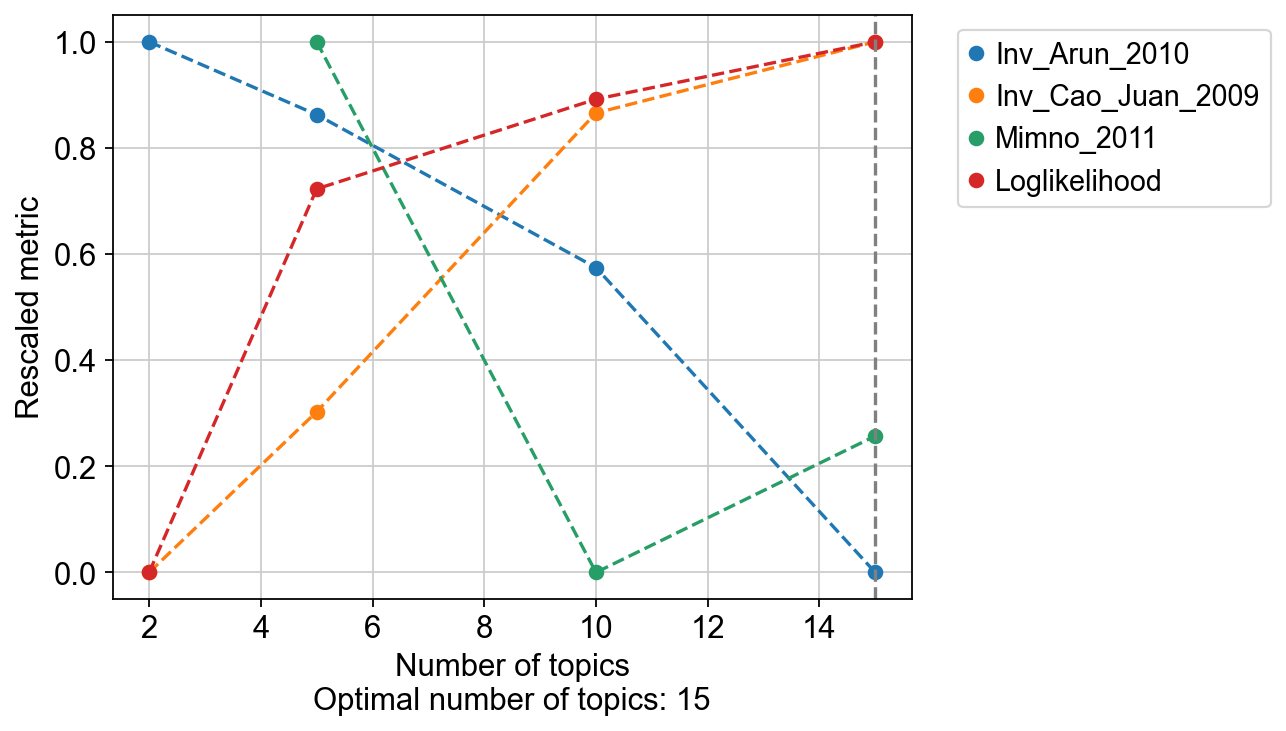

In [59]:
from pycisTopic.lda_models import evaluate_models
model = evaluate_models(
    models,
    select_model = 15,
    return_model = True
)

In [60]:
cistopic_obj.add_LDA_model(model)
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)

## Clustering and visualization

We can cluster the cells (or regions) using the leiden algorithm, and perform dimensionality reductiion with UMAP and TSNE. In these examples we will focus on the cells only. For these steps, the cell-topic contributions of the model will be used.

In [61]:
from pycisTopic.clust_vis import (
    find_clusters,
    run_umap,
    run_tsne,
    plot_metadata,
    plot_topic,
    cell_topic_heatmap
)
find_clusters(
    cistopic_obj,
    target  = 'cell',
    k = 10,
    res = [0.6, 1.2, 3],
    prefix = 'pycisTopic_',
    scale = True,
    split_pattern = '-'
)

2024-07-02 19:22:19,395 cisTopic     INFO     Finding neighbours


In [62]:
run_umap(
    cistopic_obj,
    target  = 'cell', scale=True)

2024-07-02 19:22:19,974 cisTopic     INFO     Running UMAP


/Users/merve/opt/anaconda3/envs/scenicplus/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [63]:
run_tsne(
    cistopic_obj,
    target  = 'cell', scale=True)

2024-07-02 19:22:28,004 cisTopic     INFO     Running TSNE


In [64]:
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)

In [65]:
cistopic_obj = pickle.load(open(os.path.join(out_dir, 'cistopic_obj.pkl'), 'rb'))


In [66]:
cistopic_obj.cell_data.columns


Index(['log10_total_fragments_count', 'pdf_values_for_tss_enrichment',
       'barcode_rank', 'tss_enrichment', 'unique_fragments_count',
       'unique_fragments_in_peaks_count', 'cisTopic_nr_acc',
       'duplication_ratio', 'cisTopic_nr_frag', 'log10_unique_fragments_count',
       'fraction_of_fragments_in_peaks', 'cisTopic_log_nr_frag',
       'pdf_values_for_fraction_of_fragments_in_peaks', 'cisTopic_log_nr_acc',
       'pdf_values_for_duplication_ratio', 'total_fragments_in_peaks_count',
       'log10_total_fragments_in_peaks_count',
       'log10_unique_fragments_in_peaks_count', 'total_fragments_count',
       'barcode', 'nucleosome_signal', 'duplication_count', 'n_genes',
       'doublet_score', 'predicted_doublet', 'n_genes_by_counts',
       'total_counts', 'total_counts_mt', 'pct_counts_mt',
       'ingest_celltype_label', 'leiden_res_0.8', 'celltype', 'sample_id',
       'Doublet_scores_fragments', 'Predicted_doublets_fragments',
       'pycisTopic_leiden_10_0.6', 'pycisT

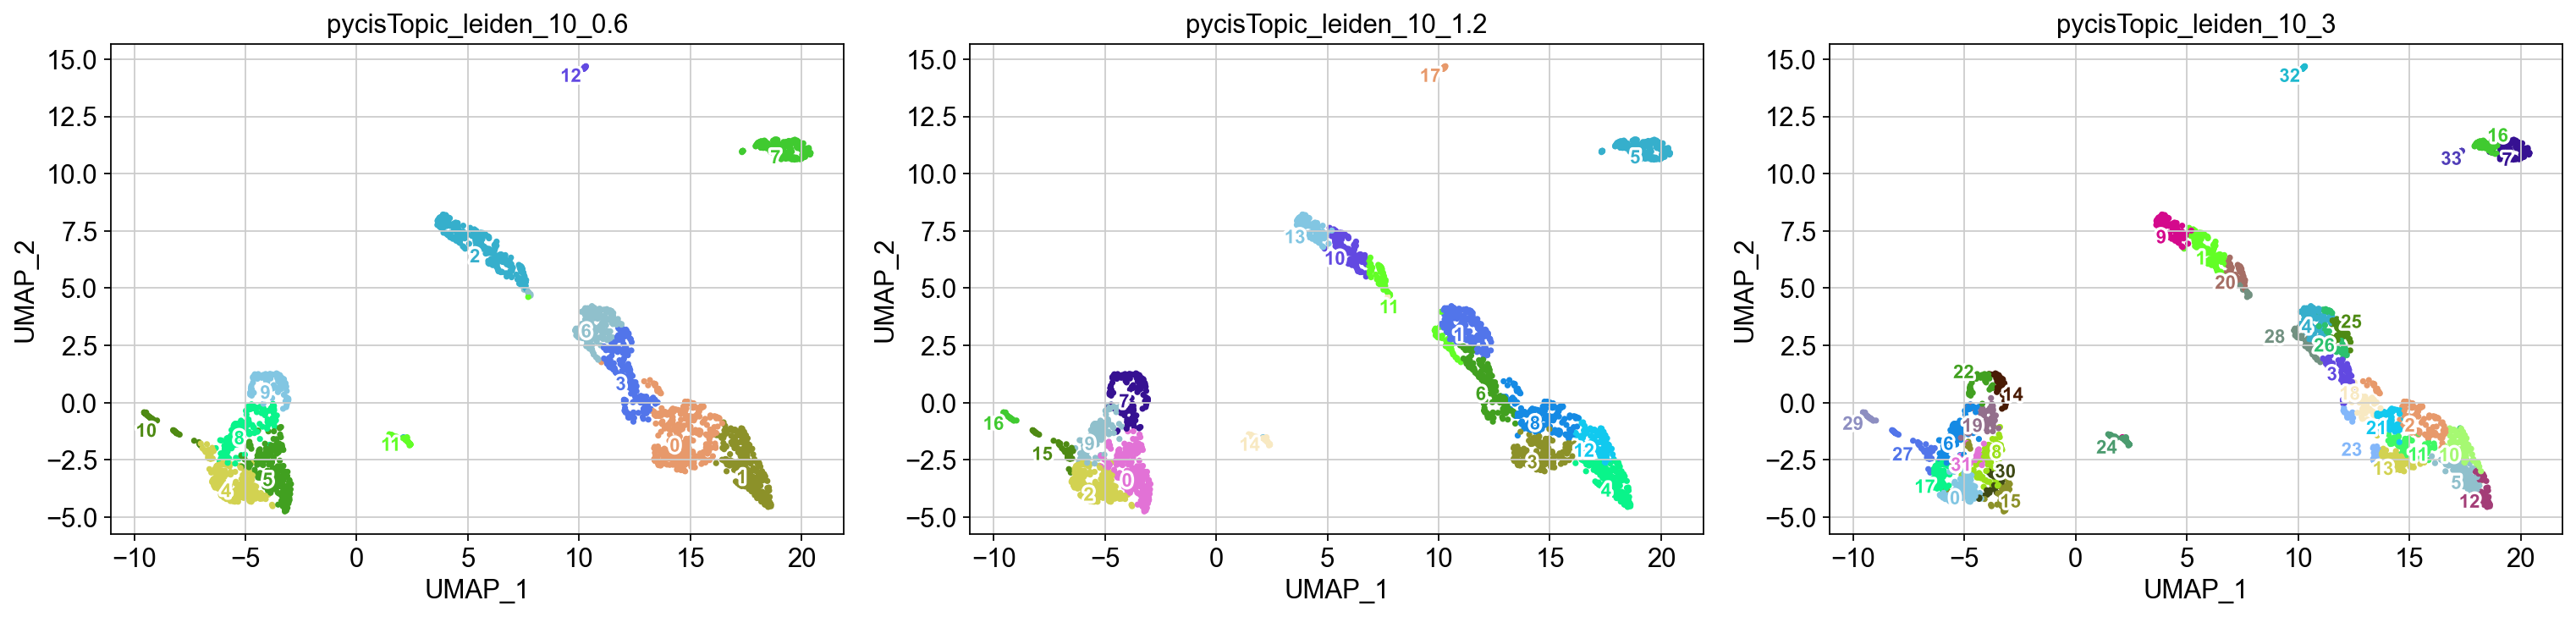

In [67]:
plot_metadata(
    cistopic_obj,
    reduction_name='UMAP',
    variables=['pycisTopic_leiden_10_0.6', 'pycisTopic_leiden_10_1.2', 'pycisTopic_leiden_10_3'],
    target='cell', num_columns=4,
    text_size=10,
    dot_size=5)

Let's annotate each cluster based on the overlap with scRNA-seq annotations.

In [68]:
annot_dict = {}
for resolution in [0.6, 1.2, 3]:
    annot_dict[f"pycisTopic_leiden_10_{resolution}"] = {}
    for cluster in set(cistopic_obj.cell_data[f"pycisTopic_leiden_10_{resolution}"]):
        counts = cistopic_obj.cell_data.loc[
            cistopic_obj.cell_data.loc[cistopic_obj.cell_data[f"pycisTopic_leiden_10_{resolution}"] == cluster].index,
            "celltype"].value_counts()
        annot_dict[f"pycisTopic_leiden_10_{resolution}"][cluster] = f"{counts.index[counts.argmax()]}({cluster})"

In [69]:
annot_dict


{'pycisTopic_leiden_10_0.6': {'11': 'CD14+_Monocytes(11)',
  '1': 'CD4_T_cells(1)',
  '3': 'CD4_T_cells(3)',
  '5': 'CD14+_Monocytes(5)',
  '2': 'CD8_T_cells(2)',
  '10': 'Dendritic_cells(10)',
  '9': 'FCGR3A+_Monocytes(9)',
  '4': 'CD14+_Monocytes(4)',
  '12': 'B_cells_2(12)',
  '6': 'CD4_T_cells(6)',
  '0': 'CD4_T_cells(0)',
  '8': 'CD14+_Monocytes(8)',
  '7': 'B_cells_1(7)'},
 'pycisTopic_leiden_10_1.2': {'11': 'CD8_T_cells(11)',
  '3': 'CD4_T_cells(3)',
  '1': 'CD4_T_cells(1)',
  '6': 'CD4_T_cells(6)',
  '5': 'B_cells_1(5)',
  '15': 'CD14+_Monocytes(15)',
  '13': 'NK_cells(13)',
  '2': 'CD14+_Monocytes(2)',
  '10': 'CD8_T_cells(10)',
  '9': 'CD14+_Monocytes(9)',
  '17': 'B_cells_2(17)',
  '4': 'CD4_T_cells(4)',
  '16': 'Dendritic_cells(16)',
  '12': 'CD4_T_cells(12)',
  '14': 'CD14+_Monocytes(14)',
  '0': 'CD14+_Monocytes(0)',
  '8': 'CD4_T_cells(8)',
  '7': 'FCGR3A+_Monocytes(7)'},
 'pycisTopic_leiden_10_3': {'1': 'CD8_T_cells(1)',
  '15': 'CD14+_Monocytes(15)',
  '27': 'CD14+_Mon

In [70]:
for resolution in [0.6, 1.2, 3]:
    cistopic_obj.cell_data[f'pycisTopic_leiden_10_{resolution}'] = [
        annot_dict[f'pycisTopic_leiden_10_{resolution}'][x] for x in cistopic_obj.cell_data[f'pycisTopic_leiden_10_{resolution}'].tolist()
    ]

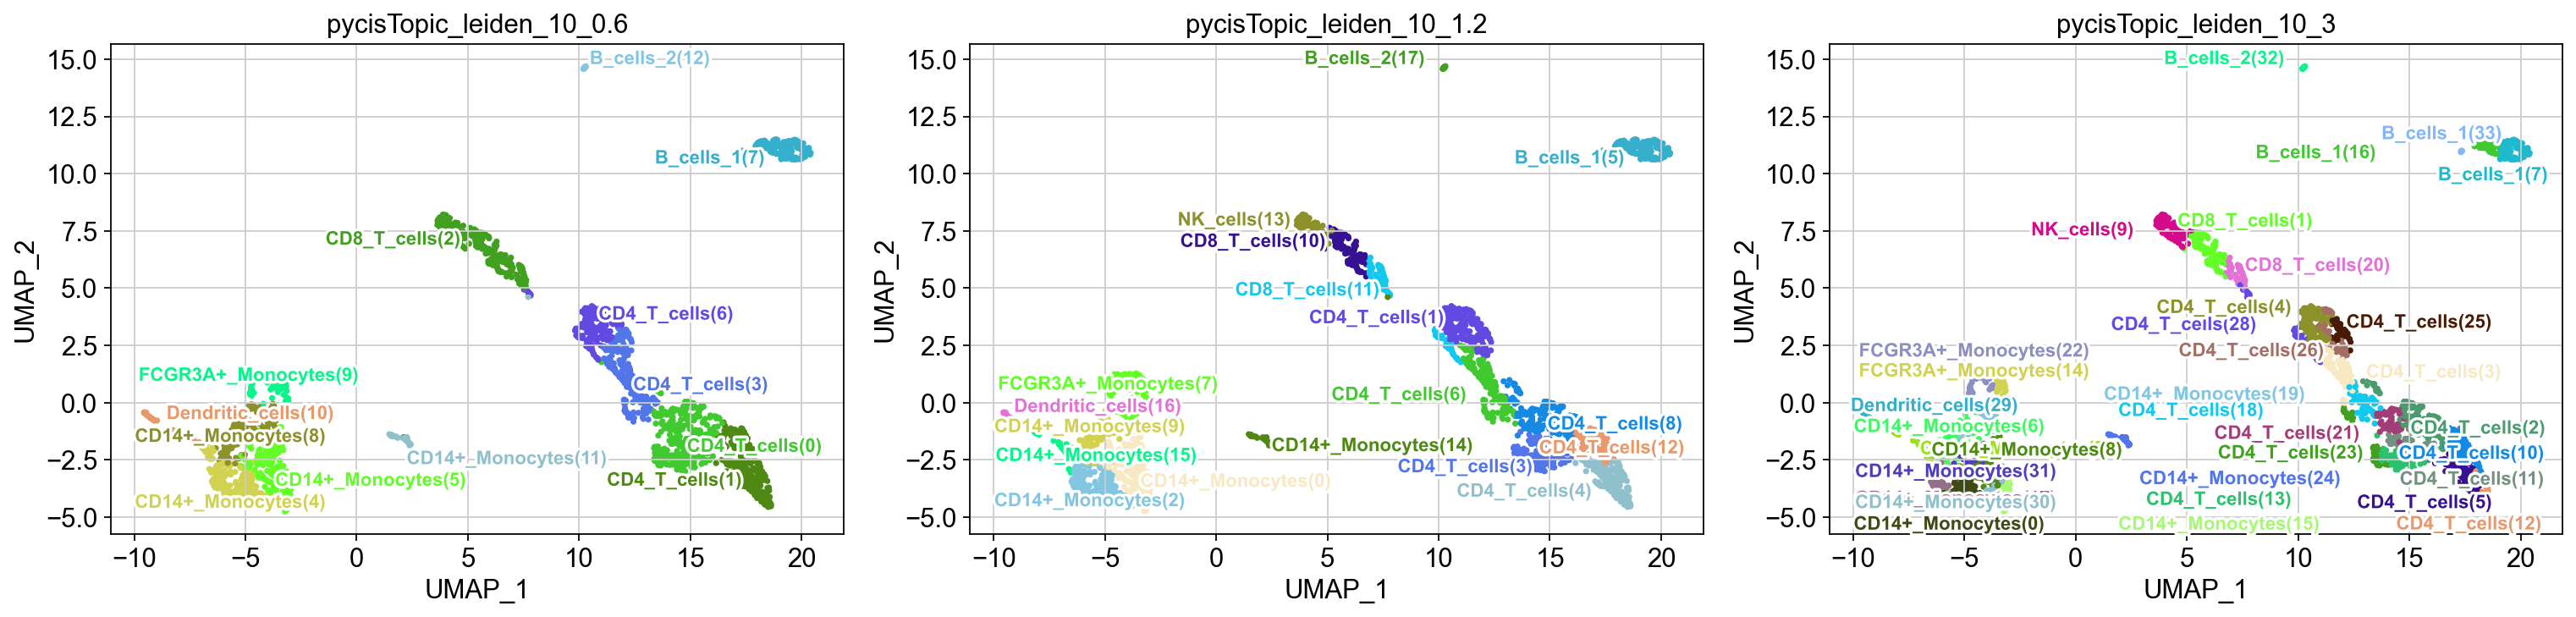

In [71]:
plot_metadata(
    cistopic_obj,
    reduction_name='UMAP',
    variables=['pycisTopic_leiden_10_0.6', 'pycisTopic_leiden_10_1.2', 'pycisTopic_leiden_10_3'],
    target='cell', num_columns=4,
    text_size=10,
    dot_size=5)

We can also plot continuous values.

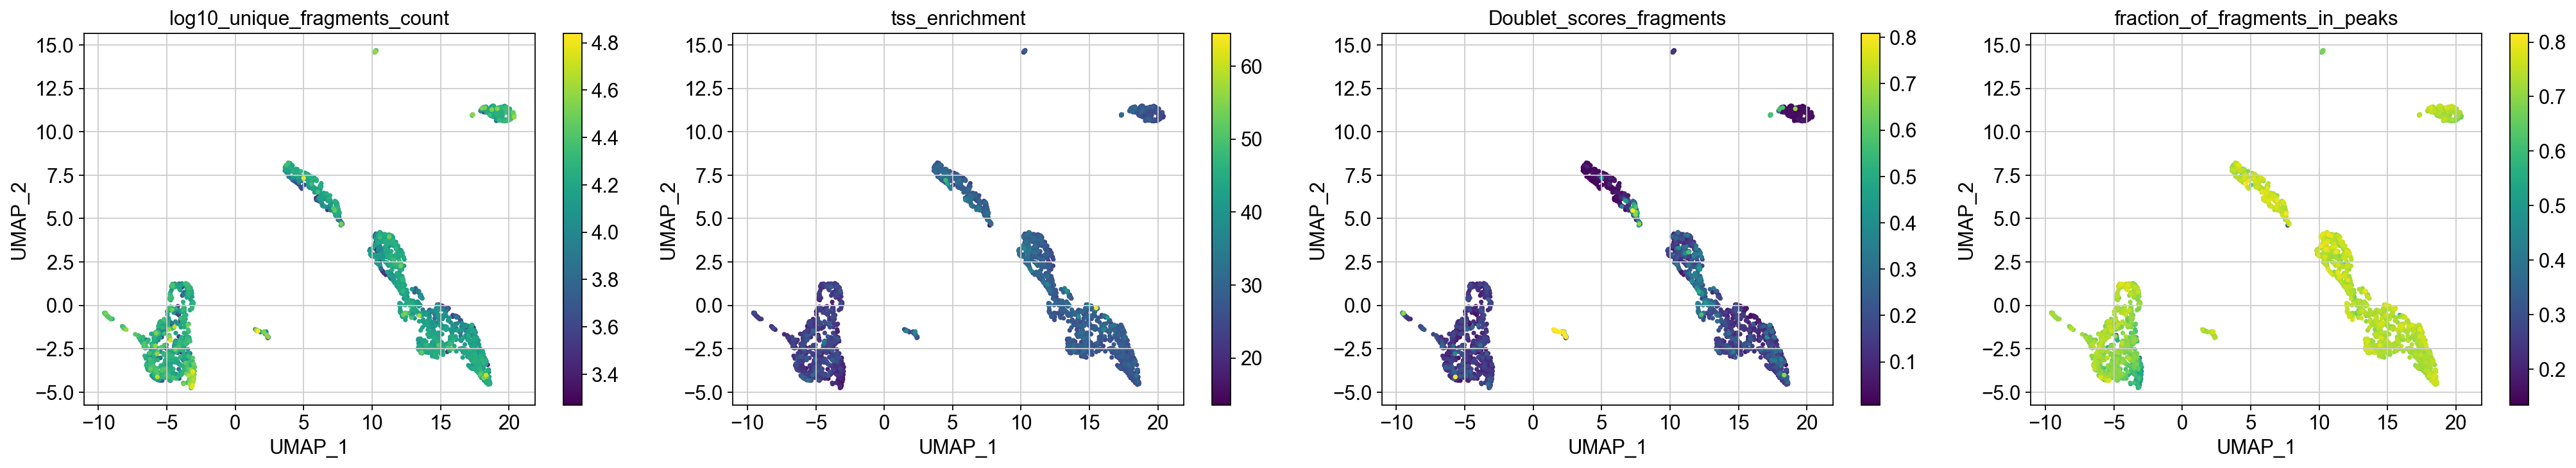

In [72]:
plot_metadata(
    cistopic_obj,
    reduction_name='UMAP',
    variables=['log10_unique_fragments_count', 'tss_enrichment', 'Doublet_scores_fragments', 'fraction_of_fragments_in_peaks'],
    target='cell', num_columns=4,
    text_size=10,
    dot_size=5)

Let's visualize the cell-topic contributions.

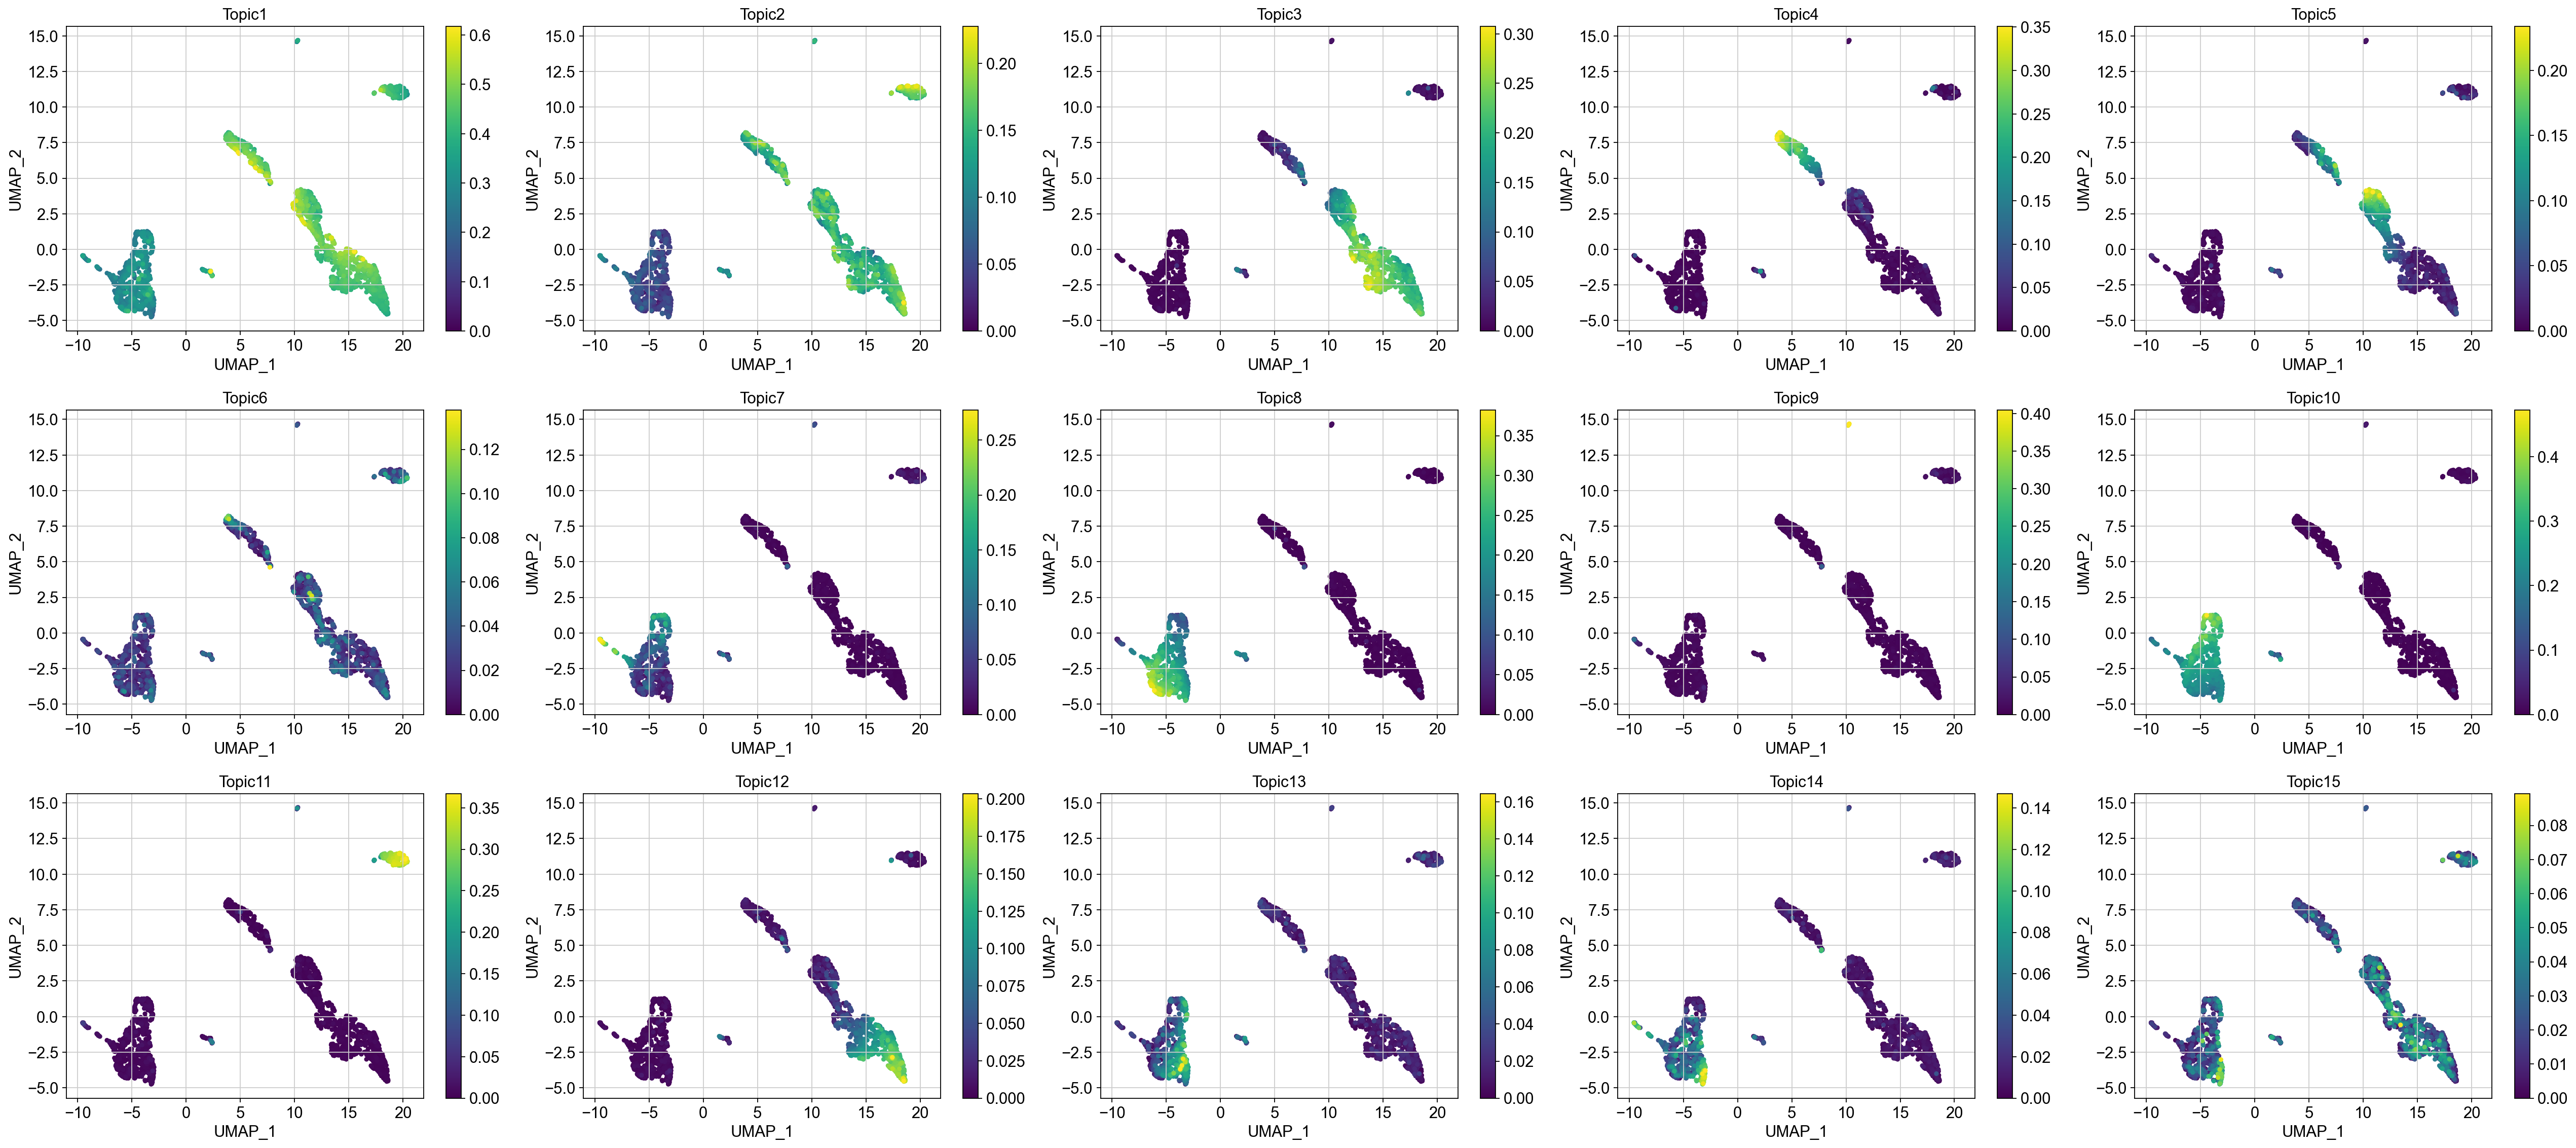

In [73]:
plot_topic(
    cistopic_obj,
    reduction_name = 'UMAP',
    target = 'cell',
    num_columns=5
)

In [74]:
cell_data

n_genes  doublet_score  predicted_doublet  \
AAACAGCCAAATATCC-1-10x_pbmc     2272       0.007582              False   
AAACAGCCAGGAACTG-1-10x_pbmc     3254       0.022142              False   
AAACAGCCAGGCTTCG-1-10x_pbmc     1798       0.039935              False   
AAACCAACACCTGCTC-1-10x_pbmc     1145       0.023256              False   
AAACCAACAGATTCAT-1-10x_pbmc     1495       0.013229              False   
...                              ...            ...                ...   
TTTGTGGCATCCGTAA-1-10x_pbmc     1346       0.007582              False   
TTTGTGGCATTAGCCA-1-10x_pbmc      972       0.026921              False   
TTTGTGGCATTGCGAC-1-10x_pbmc     2330       0.005080              False   
TTTGTGTTCCGCCTAT-1-10x_pbmc     1057       0.068845              False   
TTTGTGTTCCGTGACA-1-10x_pbmc     1513       0.002517              False   

                             n_genes_by_counts  total_counts  total_counts_mt  \
AAACAGCCAAATATCC-1-10x_pbmc               2271        4746.0            369.0   
AAACAGCCAGGAACTG-1-10x_pbmc               3253        7760.0            693.0   
AAACAGCCAGGCTTCG-1-10x_pbmc               1793        3661.0            409.0   
AAACCAACACCTGCTC-1-10x_pbmc               1142        2159.0            271.0   
AAACCAACAGATTCAT-1-10x_pbmc               1494        2909.0            293.0   
...                                        ...           ...              ...   
TTTGTGGCATCCGTAA-1-10x_pbmc               1343        2560.0            432.0   
TTTGTGGCATTAGCCA-1-10x_pbmc                969        1746.0            191.0   
TTTGTGGCATTGCGAC-1-10x_pbmc               2330        4772.0            316.0   
TTTGTGTTCCGCCTAT-1-10x_pbmc               1056        1913.0            252.0   
TTTGTGTTCCGTGACA-1-10x_pbmc               1513        2759.0            211.0   

                             pct_counts_mt ingest_celltype_label  \
AAACAGCCAAATATCC-1-10x_pbmc       7.774969              NK cells   
AAACAGCCAGGAACTG-1-10x_pbmc       8.930412       CD14+ Monocytes   
AAACAGCCAGGCTTCG-1-10x_pbmc      11.171811       CD14+ Monocytes   
AAACCAACACCTGCTC-1-10x_pbmc      12.552108               B cells   
AAACCAACAGATTCAT-1-10x_pbmc      10.072189              NK cells   
...                                    ...                   ...   
TTTGTGGCATCCGTAA-1-10x_pbmc      16.875000               B cells   
TTTGTGGCATTAGCCA-1-10x_pbmc      10.939290           CD4 T cells   
TTTGTGGCATTGCGAC-1-10x_pbmc       6.621961              NK cells   
TTTGTGTTCCGCCTAT-1-10x_pbmc      13.173027           CD4 T cells   
TTTGTGTTCCGTGACA-1-10x_pbmc       7.647698              NK cells   

                            leiden_res_0.8         celltype sample_id  
AAACAGCCAAATATCC-1-10x_pbmc             10         NK_cells  10x_pbmc  
AAACAGCCAGGAACTG-1-10x_pbmc              5  CD14+_Monocytes  10x_pbmc  
AAACAGCCAGGCTTCG-1-10x_pbmc              2  CD14+_Monocytes  10x_pbmc  
AAACCAACACCTGCTC-1-10x_pbmc              7        B_cells_1  10x_pbmc  
AAACCAACAGATTCAT-1-10x_pbmc              4      CD8_T_cells  10x_pbmc  
...                                    ...              ...       ...  
TTTGTGGCATCCGTAA-1-10x_pbmc              7        B_cells_1  10x_pbmc  
TTTGTGGCATTAGCCA-1-10x_pbmc              0      CD4_T_cells  10x_pbmc  
TTTGTGGCATTGCGAC-1-10x_pbmc             10         NK_cells  10x_pbmc  
TTTGTGTTCCGCCTAT-1-10x_pbmc              0      CD4_T_cells  10x_pbmc  
TTTGTGTTCCGTGACA-1-10x_pbmc             10         NK_cells  10x_pbmc  

[2611 rows x 11 columns]

## Topic binarization & QC

Next we can binarize topic-region and cell-topic distributions. The first is useful for exploring the topics with other tools that work with region sets (e.g. GREAT, cisTarget); while the latter is useful to automatically annotate topics.

We will first binarize the topic-region distributions. There are several methods that can be used for this: ‘otsu’ (Otsu, 1979), ‘yen’ (Yen et al., 1995), ‘li’ (Li & Lee, 1993), ‘aucell’ (Van de Sande et al., 2020) or ‘ntop’ (Taking the top n regions per topic). Otsu and Yen’s methods work well for topic-region distributions; however for some downstream analyses (e.g. deep learning) it may be convenient to use `ntop` to have balanced region sets.


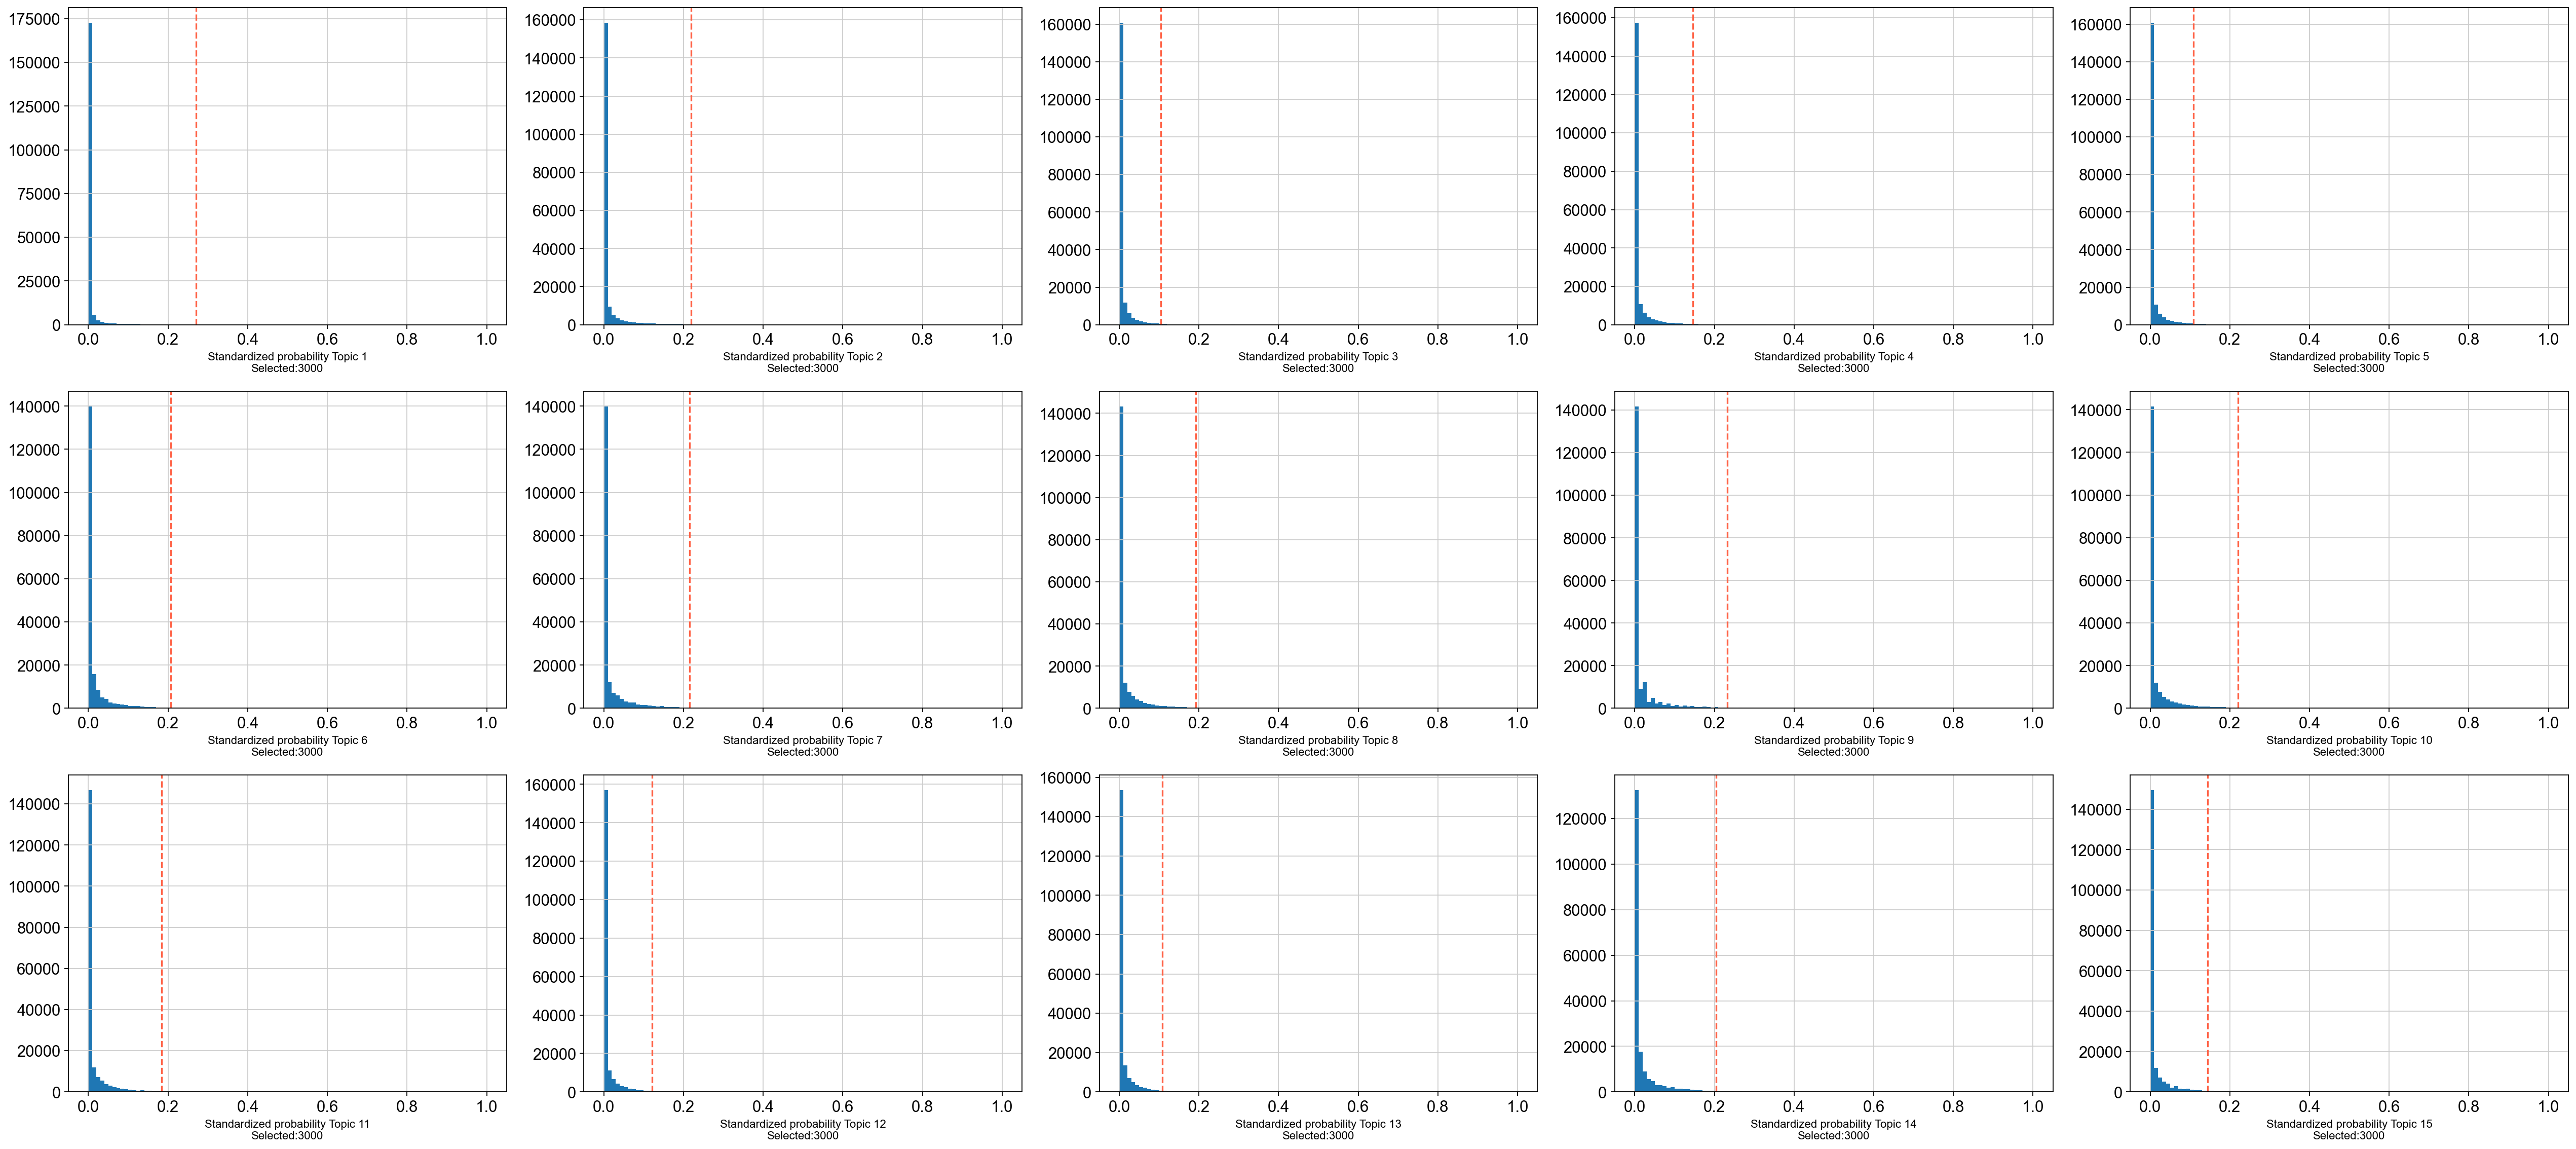

In [75]:
from pycisTopic.topic_binarization import binarize_topics
region_bin_topics_top_3k = binarize_topics(
    cistopic_obj, method='ntop', ntop = 3_000,
    plot=True, num_columns=5
)


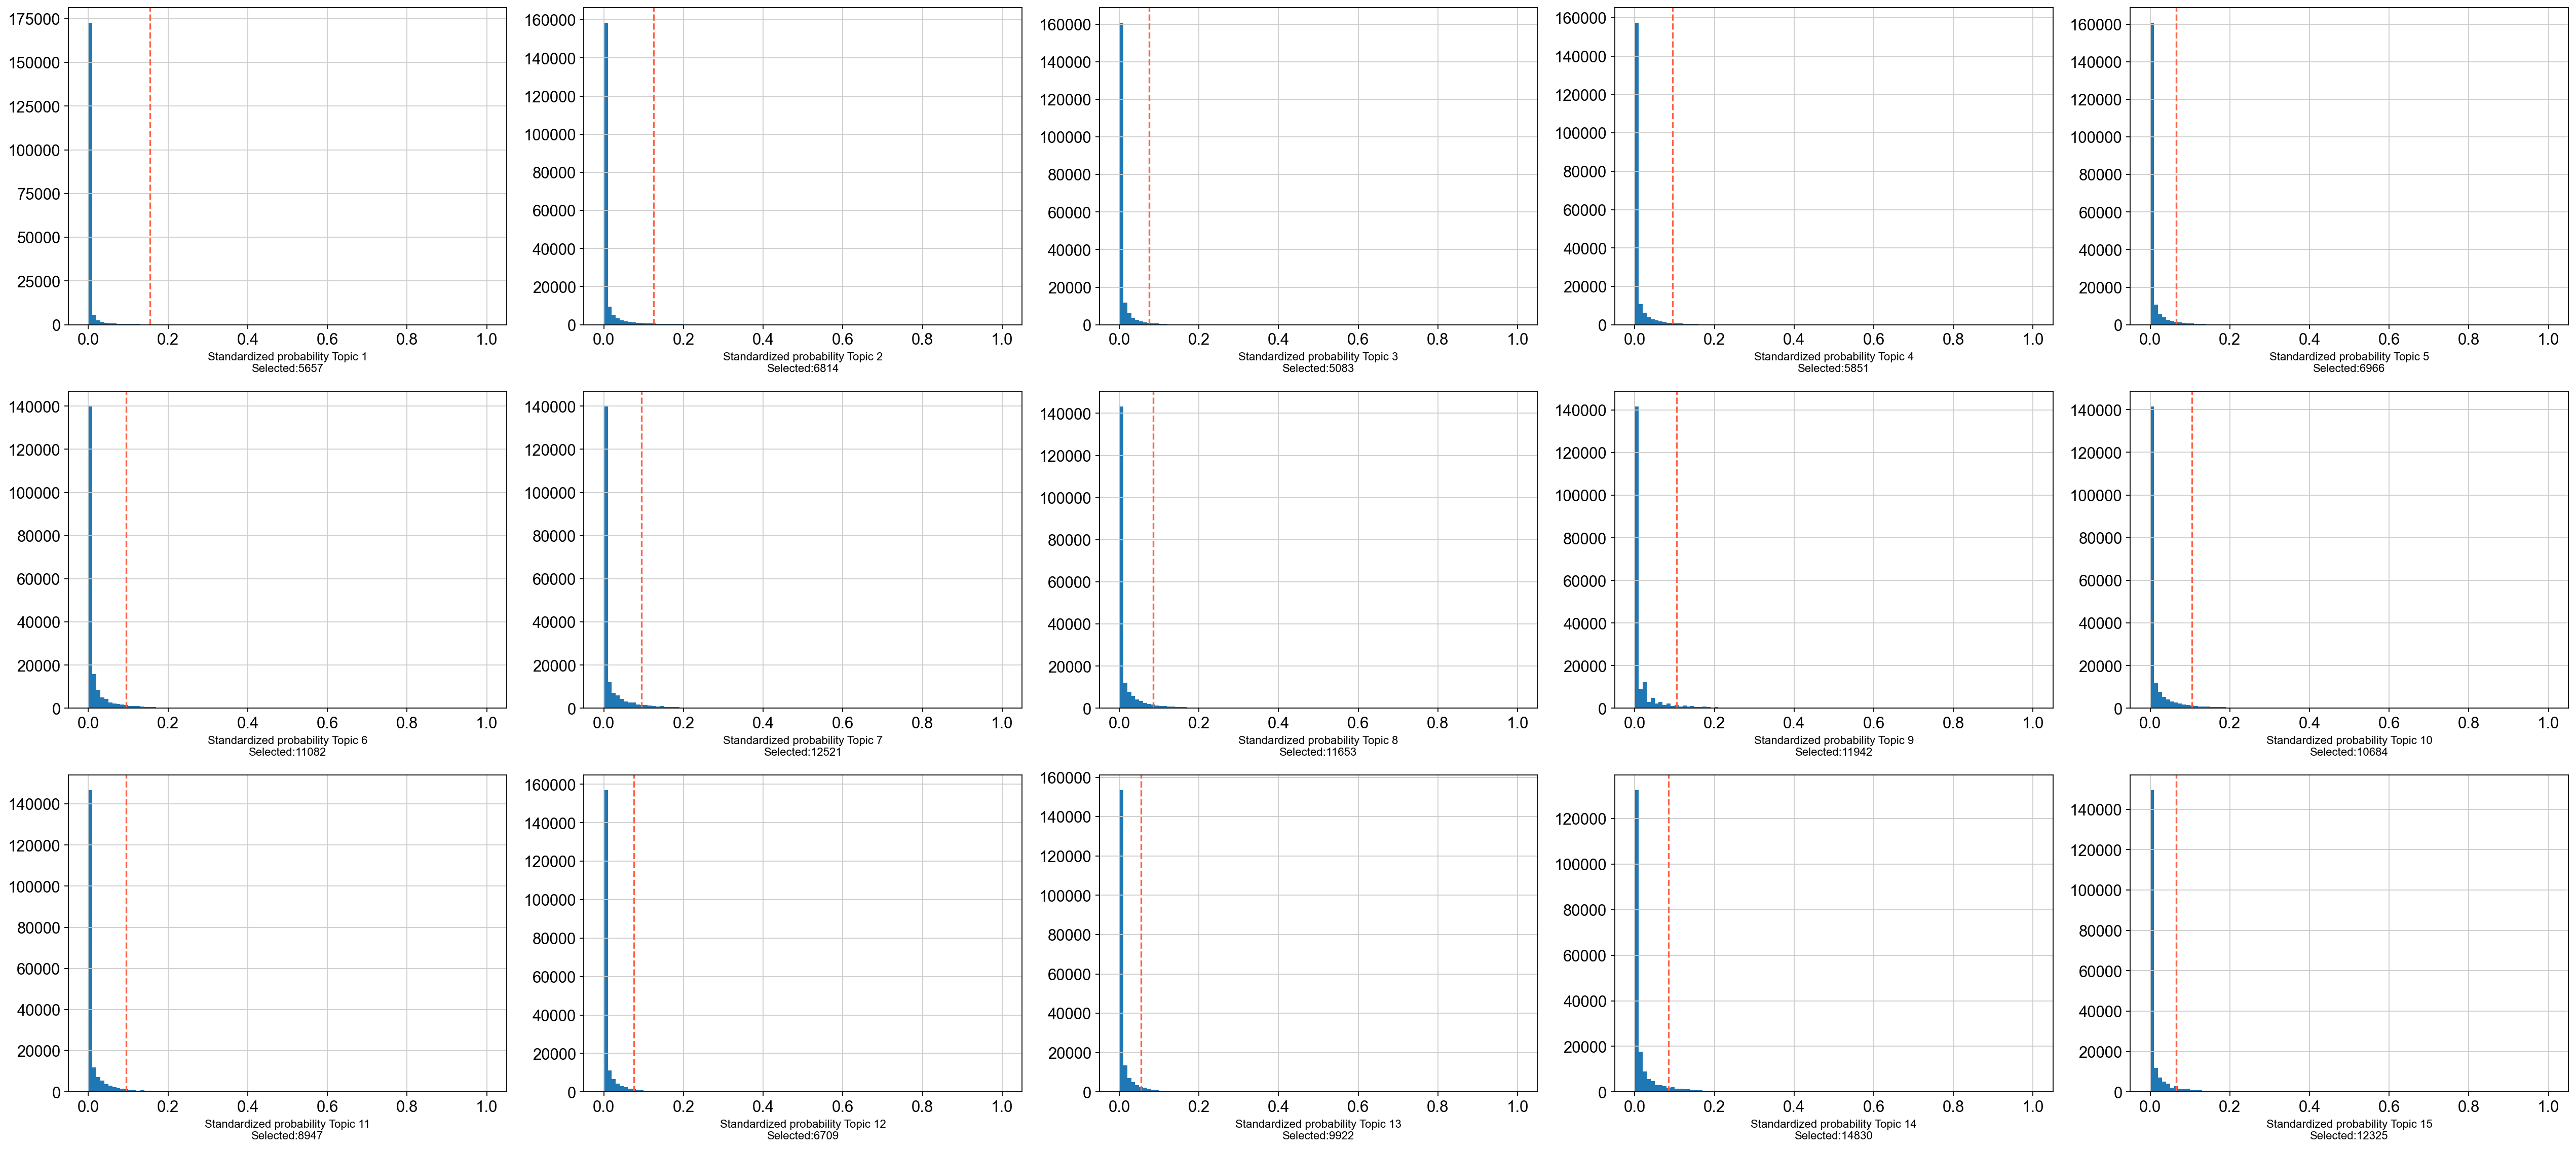

In [76]:
region_bin_topics_otsu = binarize_topics(
    cistopic_obj, method='otsu',
    plot=True, num_columns=5
)

Similarly, we can now binarize the cell-topic distribions.

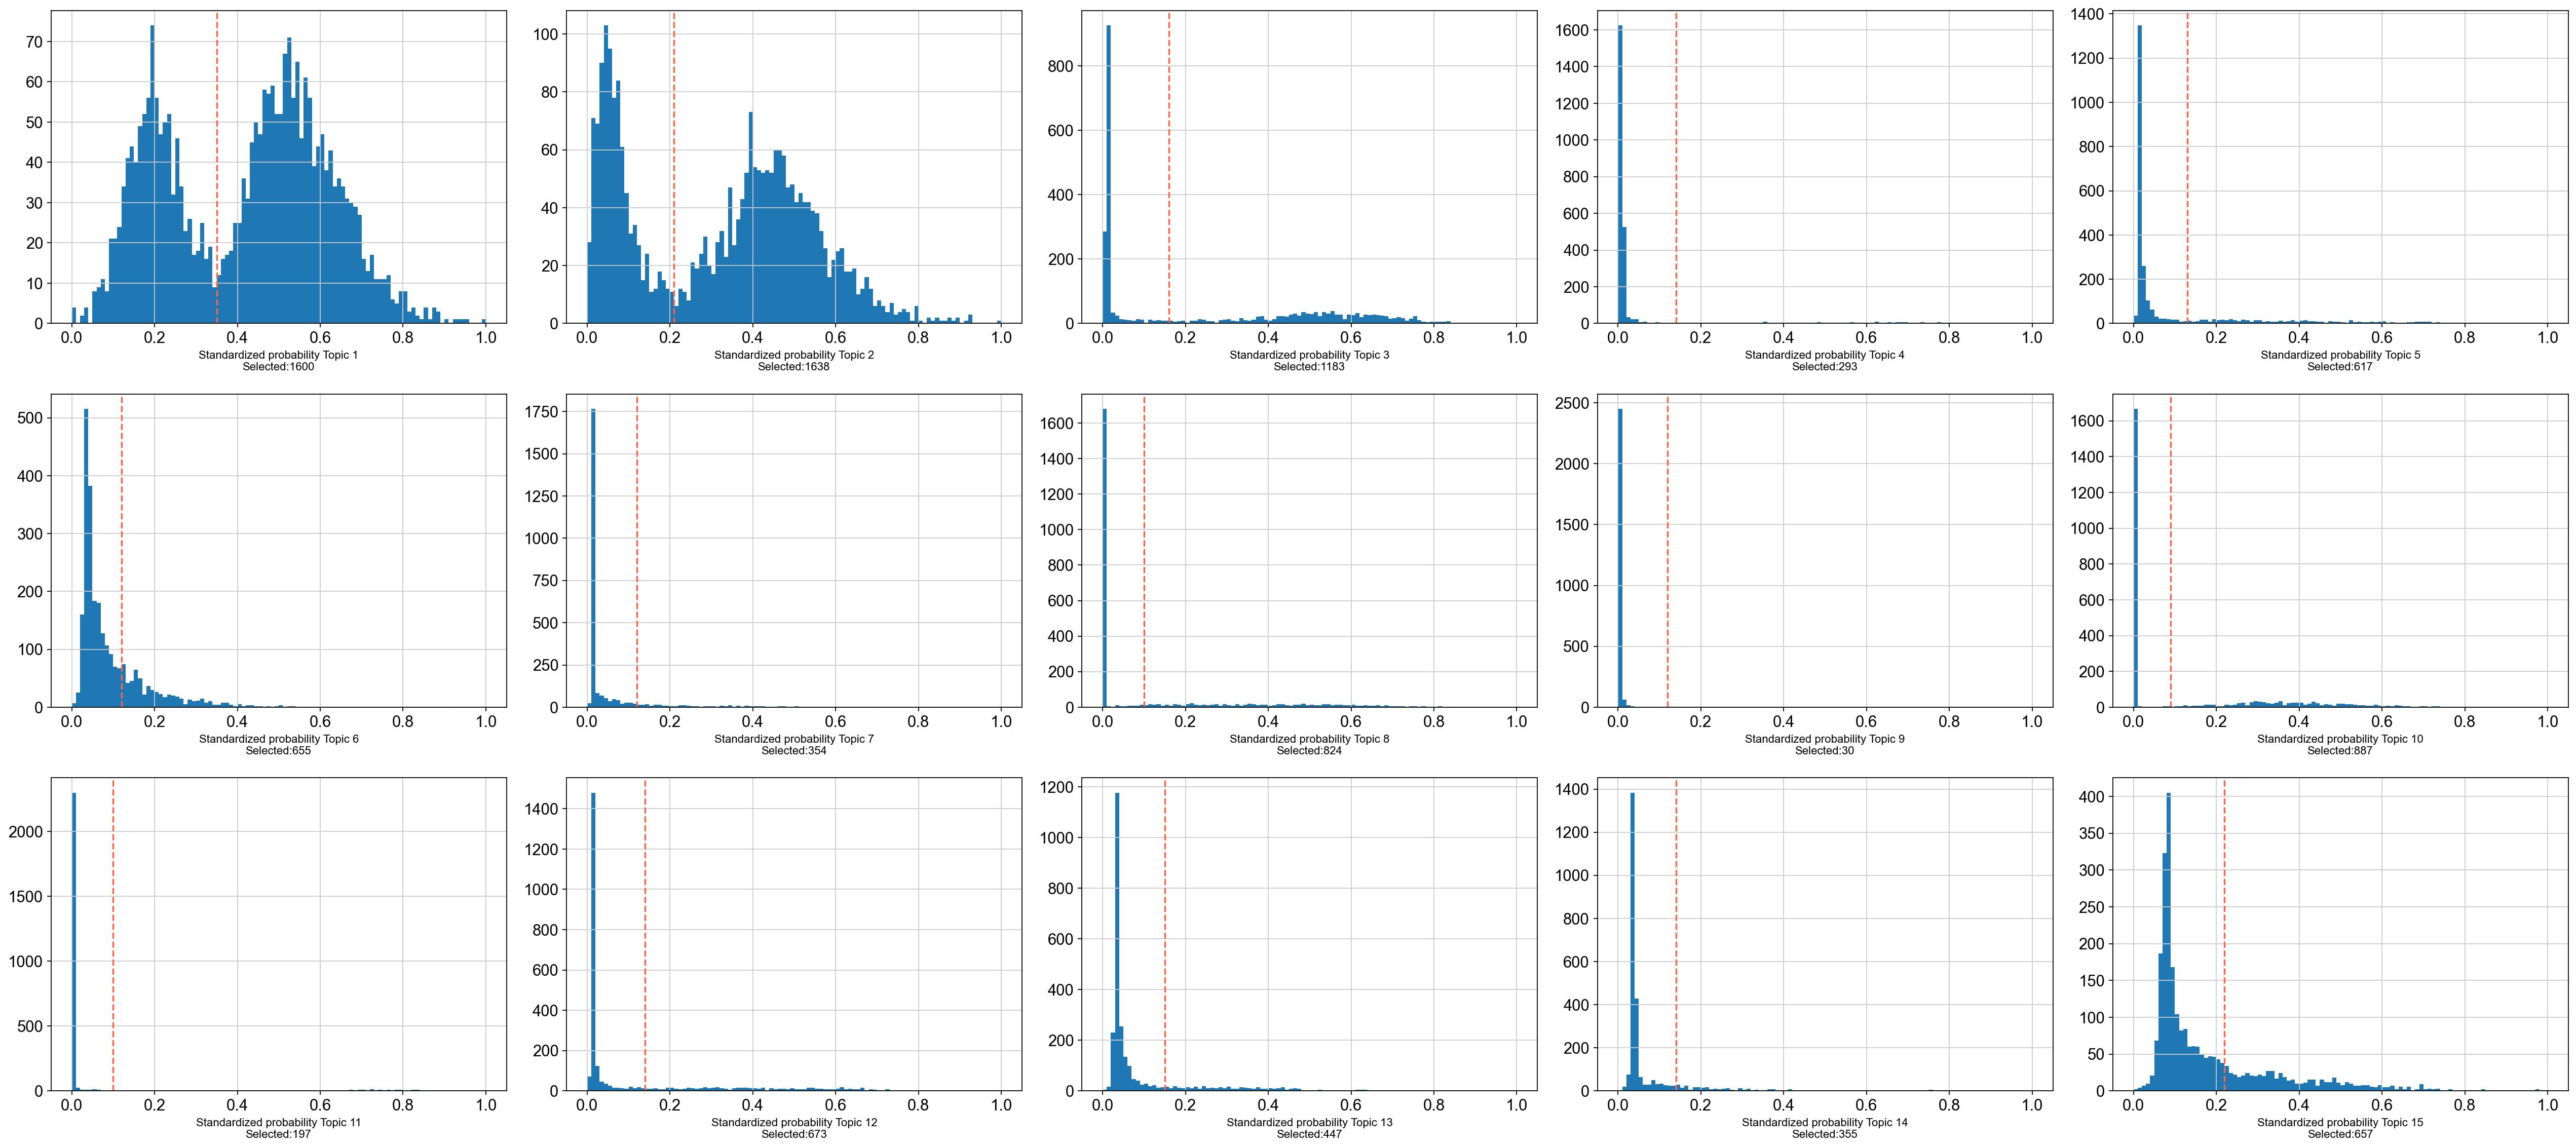

In [77]:
binarized_cell_topic = binarize_topics(
    cistopic_obj,
    target='cell',
    method='li',
    plot=True,
    num_columns=5, nbins=100)

After that, we can calculate the quality control metrics for the topics. These metrics include:

- Number of assignments
- Topic coherence (Mimno et al., 2011): This measures the extent to which highly scoring areas in the topic are accessible in the original data. A low score indicates a random topic, while a higher score indicates a better topic.
- The marginal topic distribution: This shows how much each topic contributes to the model. The higher the distribution, the better the topic.
- The Gini index: A value between 0 and 1 that indicates the specificity of topics (0: General, 1: Specific).
- The number of regions/cells per topic, if topics have been binarized.

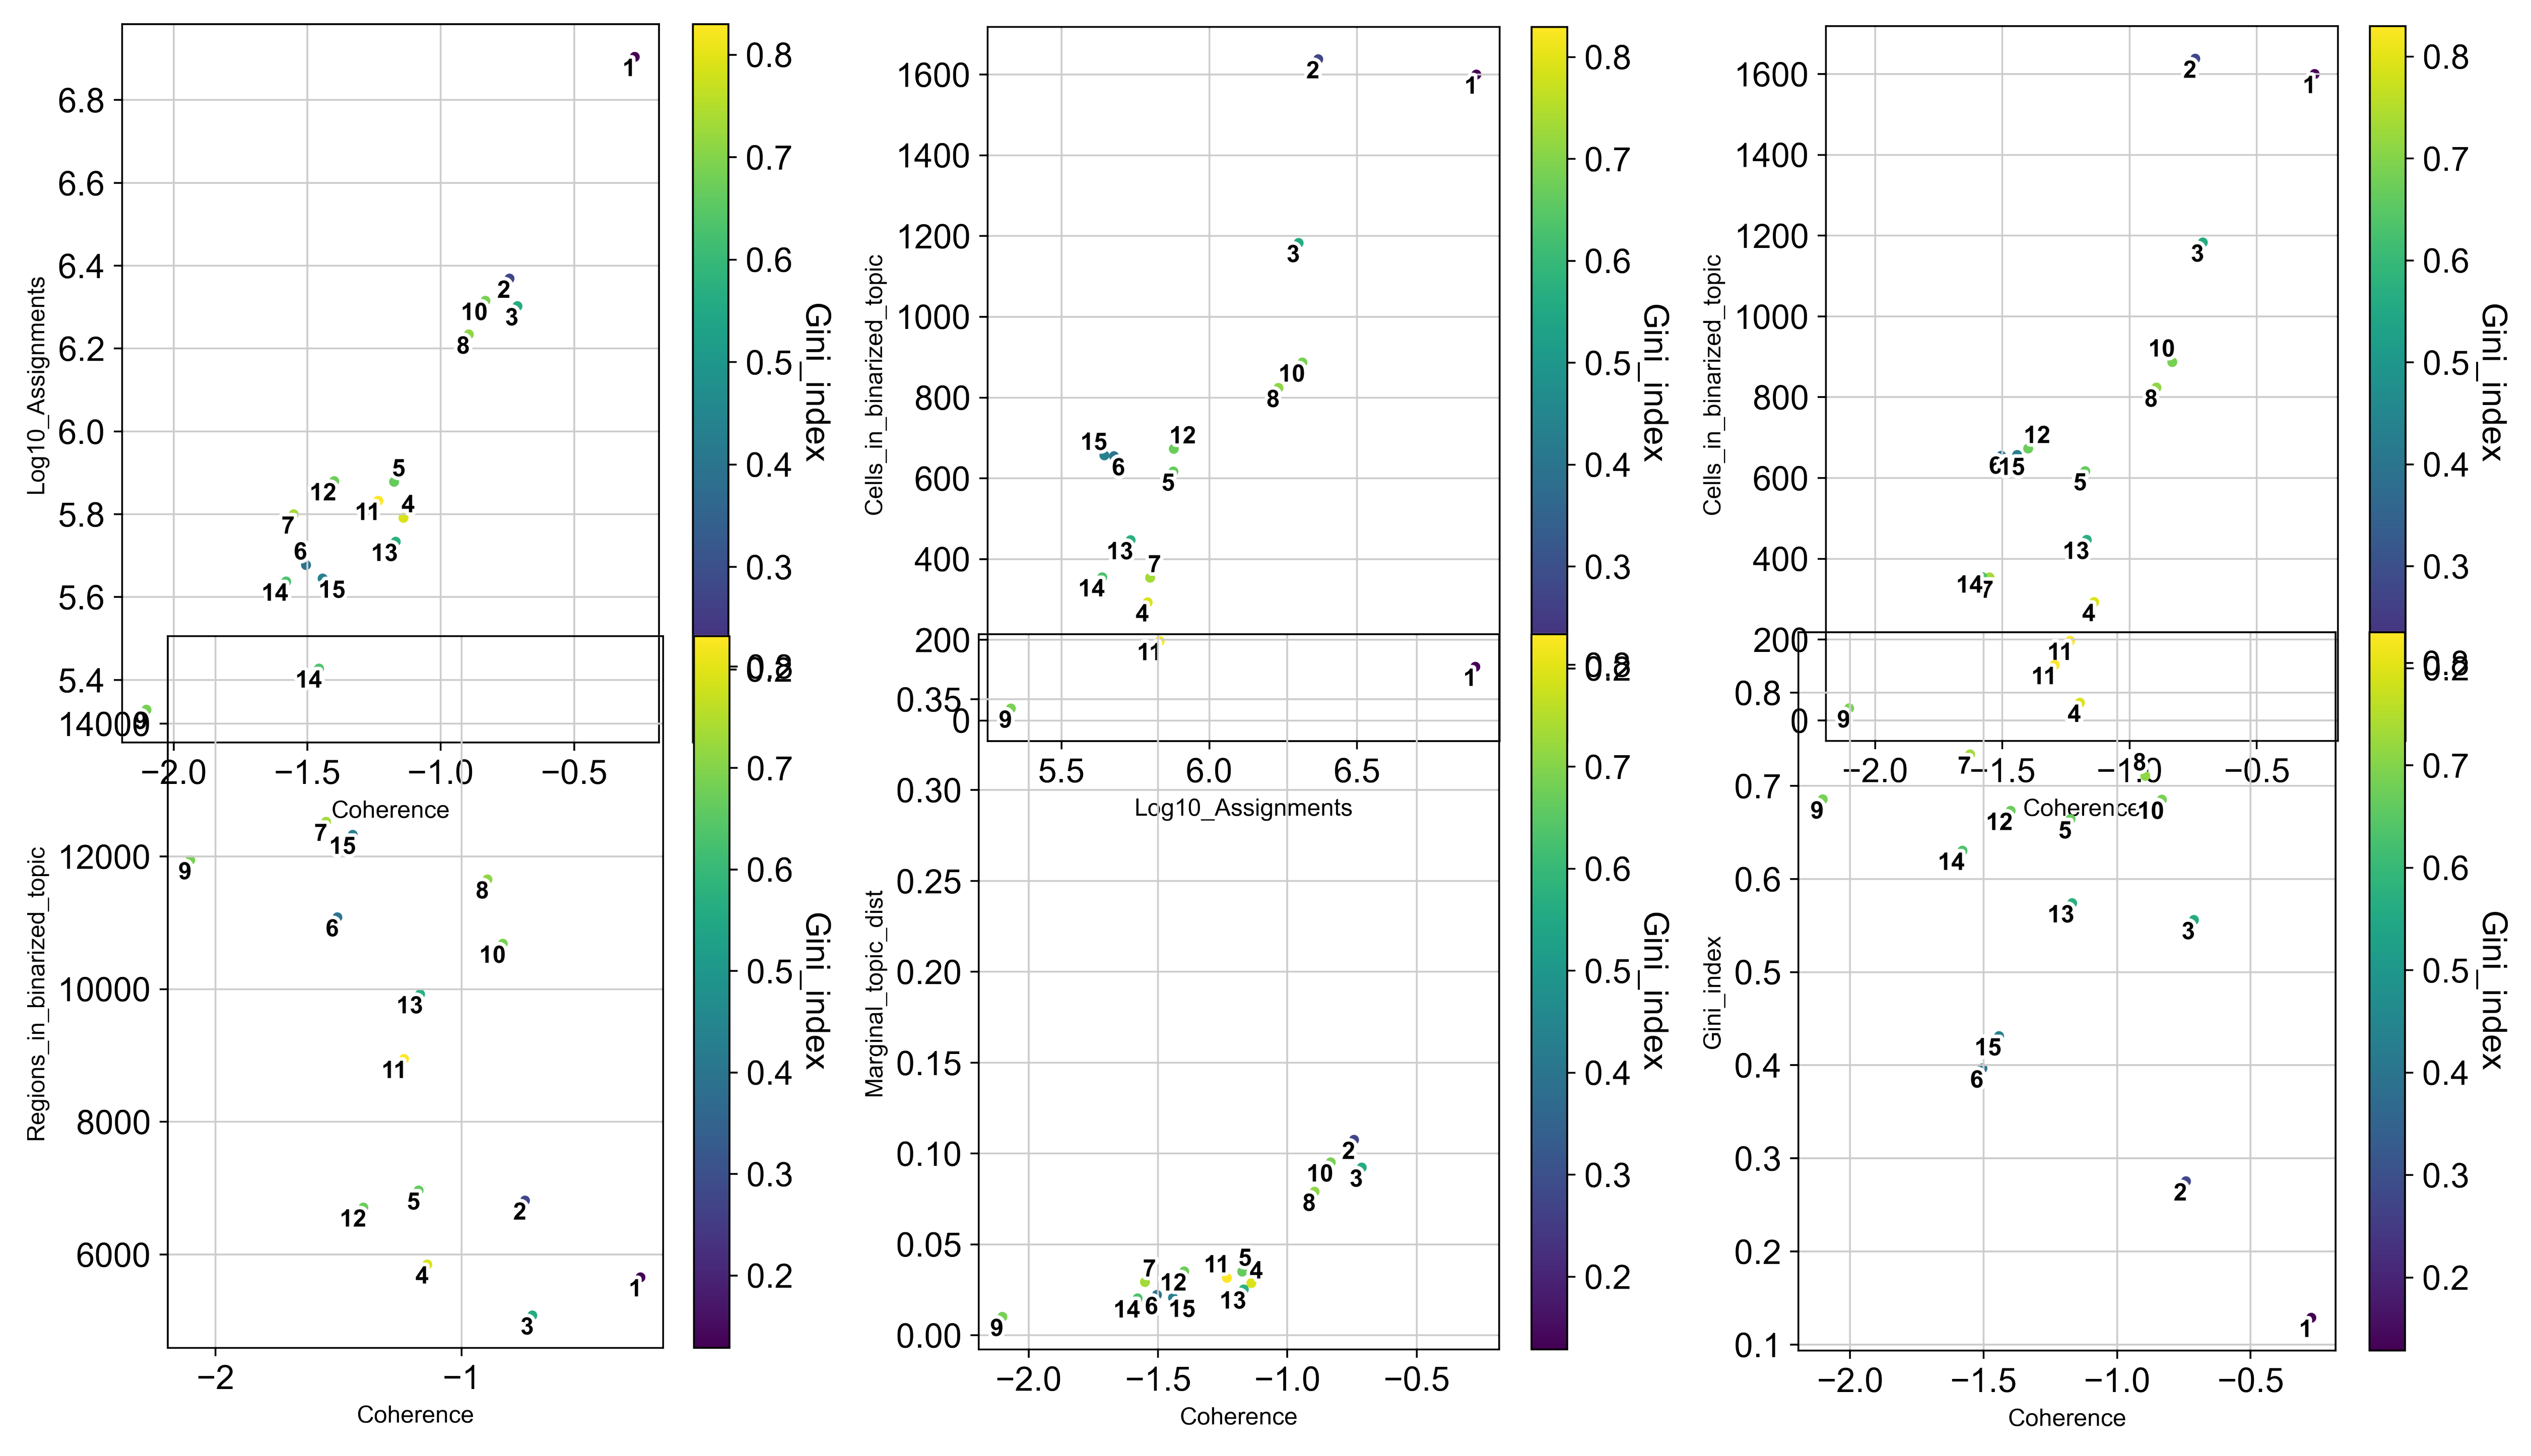

In [78]:
from pycisTopic.topic_qc import compute_topic_metrics, plot_topic_qc, topic_annotation
import matplotlib.pyplot as plt
from pycisTopic.utils import fig2img
topic_qc_metrics = compute_topic_metrics(cistopic_obj)
fig_dict={}
fig_dict['CoherenceVSAssignments']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Log10_Assignments', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['AssignmentsVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Log10_Assignments', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSRegions_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Regions_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSMarginal_dist']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Marginal_topic_dist', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSGini_index']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Gini_index', var_color='Gini_index', plot=False, return_fig=True)
# Plot topic stats in one figure
fig=plt.figure(figsize=(40, 43))
i = 1
for fig_ in fig_dict.keys():
    plt.subplot(2, 3, i)
    img = fig2img(fig_dict[fig_]) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
    plt.imshow(img)
    plt.axis('off')
    i += 1
plt.subplots_adjust(wspace=0, hspace=-0.70)
plt.show()

Next, we can automatically annotate topics, in this case by cell type. Here we calculate the proportion of cells in each group that are assigned to the binarized topic in comparison to the ratio in the whole data set. We will consider a topic as general if the difference between the ratio of cells in the whole data set in the binarized topic and the ratio of total cells in the assigned groups is above 0.2. This indicates that the topic is general, and the proportion test may fail, if the topic is enriched in both foreground (the group) and background (the whole data set); resulting in a big difference between the ratios.

In [79]:
topic_annot = topic_annotation(
    cistopic_obj,
    annot_var='celltype',
    binarized_cell_topic=binarized_cell_topic,
    general_topic_thr = 0.2
)

/Users/merve/opt/anaconda3/envs/scenicplus/lib/python3.11/site-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: divide by zero encountered in scalar divide
  zstat = value / std


In [80]:
topic_annot


celltype  \
Topic1       CD8_T_cells, B_cells_1, CD4_T_cells, NK_cells   
Topic2   B_cells_2, CD8_T_cells, B_cells_1, CD4_T_cells...   
Topic3                                         CD4_T_cells   
Topic4                               CD8_T_cells, NK_cells   
Topic5                            CD8_T_cells, CD4_T_cells   
Topic6                    B_cells_1, CD4_T_cells, NK_cells   
Topic7   FCGR3A+_Monocytes, CD14+_Monocytes, Dendritic_...   
Topic8                  FCGR3A+_Monocytes, CD14+_Monocytes   
Topic9                                           B_cells_2   
Topic10  FCGR3A+_Monocytes, CD14+_Monocytes, Dendritic_...   
Topic11                                          B_cells_1   
Topic12                                        CD4_T_cells   
Topic13                 FCGR3A+_Monocytes, CD14+_Monocytes   
Topic14                   CD14+_Monocytes, Dendritic_cells   
Topic15                                        CD4_T_cells   

        Ratio_cells_in_topic Ratio_group_in_population  is_general  
Topic1              0.622084                  0.619751       False  
Topic2              0.636858                  0.630638       False  
Topic3              0.459953                  0.438569       False  
Topic4              0.113919                   0.11353       False  
Topic5              0.239891                  0.519829       False  
Topic6              0.254666                  0.538491       False  
Topic7              0.137636                  0.328149       False  
Topic8              0.320373                  0.312208       False  
Topic9              0.011664                  0.010886       False  
Topic10             0.344868                  0.328149       False  
Topic11             0.076594                  0.067652       False  
Topic12             0.261664                  0.438569       False  
Topic13             0.173795                  0.312208       False  
Topic14             0.138025                  0.284603       False  
Topic15             0.255443                  0.438569       False

## Differentially Accessible Regions (DARs)

Together with working with regulatory topics, we can also identify differentially accessible regions (DARs) between cell types. First, we will impute the region accessibility by exploiting the cell-topic and topic-region probabilities. To shrink very low probability values to 0, we use a scale factor (by default: 10^6).

In [81]:
from pycisTopic.diff_features import (
    impute_accessibility,
    normalize_scores,
    find_highly_variable_features,
    find_diff_features
)

In [82]:
import numpy as np

In [83]:
imputed_acc_obj = impute_accessibility(
    cistopic_obj,
    selected_cells=None,
    selected_regions=None,
    scale_factor=10**6
)

2024-07-02 19:23:14,335 cisTopic     INFO     Imputing region accessibility
2024-07-02 19:23:14,336 cisTopic     INFO     Impute region accessibility for regions 0-20000
2024-07-02 19:23:14,810 cisTopic     INFO     Impute region accessibility for regions 20000-40000
2024-07-02 19:23:15,114 cisTopic     INFO     Impute region accessibility for regions 40000-60000
2024-07-02 19:23:15,409 cisTopic     INFO     Impute region accessibility for regions 60000-80000
2024-07-02 19:23:15,707 cisTopic     INFO     Impute region accessibility for regions 80000-100000
2024-07-02 19:23:16,001 cisTopic     INFO     Impute region accessibility for regions 100000-120000
2024-07-02 19:23:16,299 cisTopic     INFO     Impute region accessibility for regions 120000-140000
2024-07-02 19:23:16,594 cisTopic     INFO     Impute region accessibility for regions 140000-160000
2024-07-02 19:23:16,888 cisTopic     INFO     Impute region accessibility for regions 160000-180000
2024-07-02 19:23:17,184 cisTopic     

In [84]:
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)


2024-07-02 19:23:17,447 cisTopic     INFO     Normalizing imputed data
2024-07-02 19:23:23,485 cisTopic     INFO     Done!


Optionally, we can identify highly variable regions. This is not mandatory but will speed up the hypothesis testing step for identifying DARs.

2024-07-02 19:23:23,491 cisTopic     INFO     Calculating mean
2024-07-02 19:23:23,989 cisTopic     INFO     Calculating variance


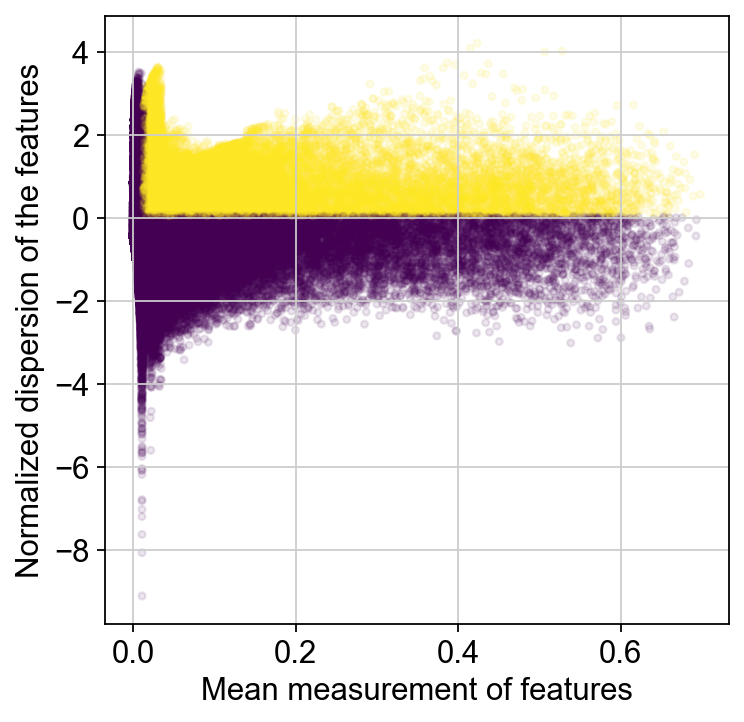

2024-07-02 19:23:33,396 cisTopic     INFO     Done!


53692

In [85]:
variable_regions = find_highly_variable_features(
    normalized_imputed_acc_obj,
    min_disp = 0.05,
    min_mean = 0.0125,
    max_mean = 3,
    max_disp = np.inf,
    n_bins=20,
    n_top_features=None,
    plot=True
)
len(variable_regions)

We can now identify differentially accessible regions between groups. By default, this function will perform a Wilcoxon rank-sum test between each group using the specified variable and the rest. Alternatively, specified contrast can be provided as a list with foreground and background groups (e.g. for group 1 versus group 2 and 3, and group 2 versus group 1 and 3: `[[[‘Group_1’], [‘Group_2, ‘Group_3’]], [[‘Group_2’], [‘Group_1, ‘Group_3’]]]`).

In [86]:
markers_dict= find_diff_features(
    cistopic_obj,
    imputed_acc_obj,
    variable='celltype',
    var_features=variable_regions,
    contrasts=None,
    adjpval_thr=0.05,
    log2fc_thr=np.log2(1.5),
    #n_cpu=5,
    _temp_dir = os.path.join(tmp_dir, 'ray_spill'),
    split_pattern = '-'
)

2024-07-02 19:23:34,104 cisTopic     INFO     Subsetting data for B_cells_1 (174 of 2572)
2024-07-02 19:23:37,174 cisTopic     INFO     Computing p-value for B_cells_1
2024-07-02 19:24:02,047 cisTopic     INFO     Computing log2FC for B_cells_1
2024-07-02 19:24:03,453 cisTopic     INFO     B_cells_1 done!
2024-07-02 19:24:03,495 cisTopic     INFO     Subsetting data for B_cells_2 (28 of 2572)
2024-07-02 19:24:03,556 cisTopic     INFO     Computing p-value for B_cells_2
2024-07-02 19:24:29,719 cisTopic     INFO     Computing log2FC for B_cells_2
2024-07-02 19:24:29,771 cisTopic     INFO     B_cells_2 done!
2024-07-02 19:24:29,814 cisTopic     INFO     Subsetting data for CD14+_Monocytes (691 of 2572)
2024-07-02 19:24:29,890 cisTopic     INFO     Computing p-value for CD14+_Monocytes
2024-07-02 19:24:56,312 cisTopic     INFO     Computing log2FC for CD14+_Monocytes
2024-07-02 19:24:56,402 cisTopic     INFO     CD14+_Monocytes done!
2024-07-02 19:24:56,444 cisTopic     INFO     Subsetting

We can also plot region accessibility onto the cell-topic UMAP. For example, let’s check how the best DARs for some cell types look like.

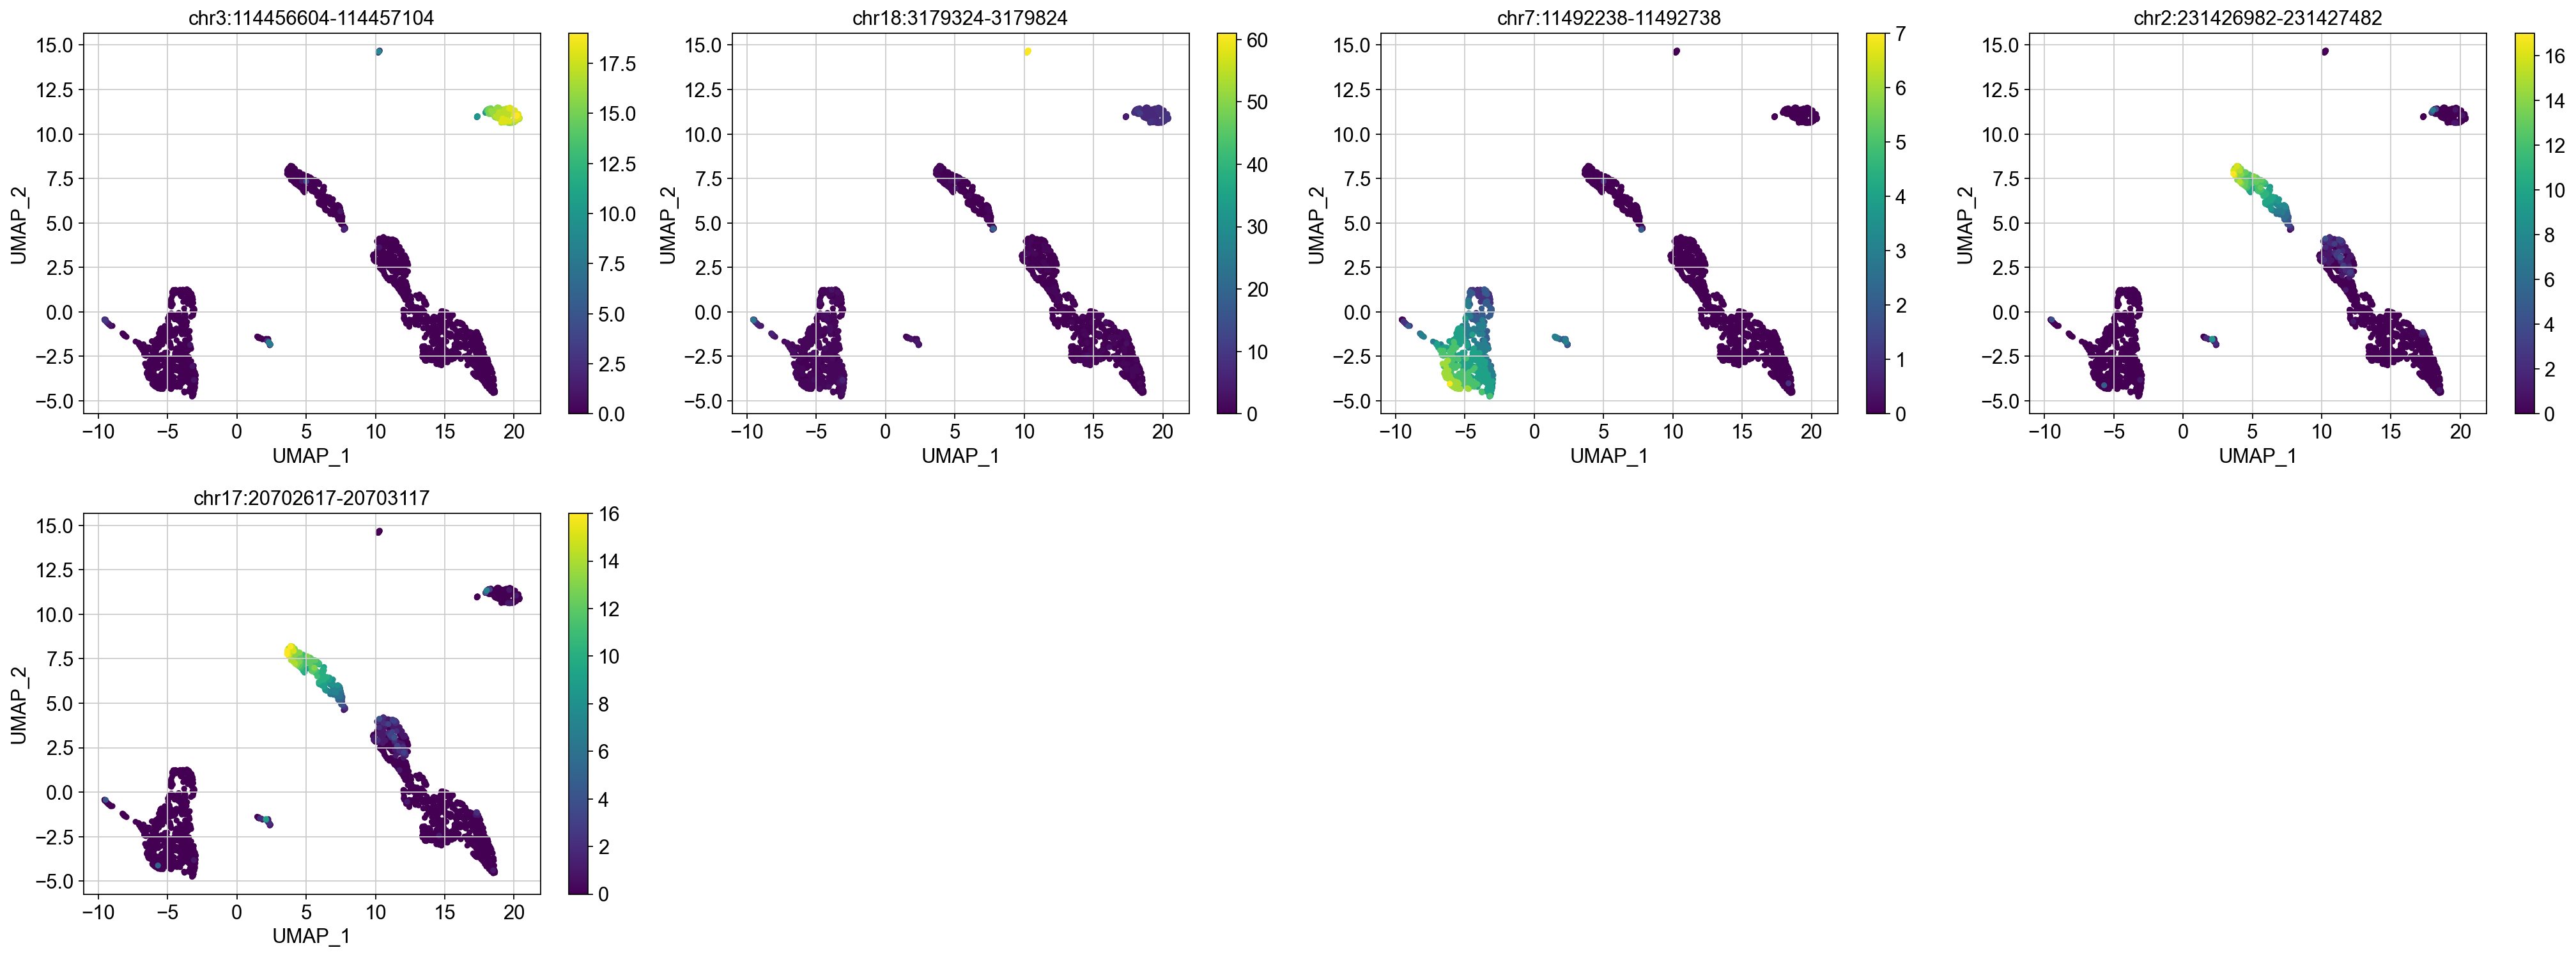

In [87]:
from pycisTopic.clust_vis import plot_imputed_features
plot_imputed_features(
    cistopic_obj,
    reduction_name='UMAP',
    imputed_data=imputed_acc_obj,
    features=[markers_dict[x].index.tolist()[0] for x in ['B_cells_1', 'B_cells_2', 'CD14+_Monocytes', 'CD8_T_cells', 'NK_cells']],
    scale=False,
    num_columns=4
)

In [88]:
print("Number of DARs found:")
print("---------------------")
for x in markers_dict:
    print(f"  {x}: {len(markers_dict[x])}")

Number of DARs found:
---------------------
  B_cells_1: 9948
  B_cells_2: 10656
  CD14+_Monocytes: 29474
  CD4_T_cells: 14017
  CD8_T_cells: 8239
  Dendritic_cells: 22767
  FCGR3A+_Monocytes: 25033
  NK_cells: 7453


## Save region sets

In [89]:
os.makedirs(os.path.join(out_dir, "region_sets"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "region_sets", "Topics_otsu"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "region_sets", "Topics_top_3k"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "region_sets", "DARs_cell_type"), exist_ok = True)

In [90]:
from pycisTopic.utils import region_names_to_coordinates
for topic in region_bin_topics_otsu:
    region_names_to_coordinates(
        region_bin_topics_otsu[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "region_sets", "Topics_otsu", f"{topic}.bed"),
        sep = "\t",
        header = False, index = False
    )
for topic in region_bin_topics_top_3k:
    region_names_to_coordinates(
        region_bin_topics_top_3k[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "region_sets", "Topics_top_3k", f"{topic}.bed"),
        sep = "\t",
        header = False, index = False
    )
for cell_type in markers_dict:
    region_names_to_coordinates(
        markers_dict[cell_type].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "region_sets", "DARs_cell_type", f"{cell_type}.bed"),
        sep = "\t",
        header = False, index = False
    )

## Gene activity

In this function, there are several options to evaluate: 
- **Search space**: The user can choose whether the search space should include other genes or not (use_gene_boundaries), and the minimum and maximum distance it should have (upstream and downstream) 
- **Distance weight**: The parameters related to the distance weight measure the impact of distance when inferring region to gene weights as an exponential function. The user can control whether this weight should be used (distance_weight) and the effect of the distance (decay_rate).
- **Gene size weight**: Large genes may have more peaks by chance. The user can optionally apply a weight based on the size of each gene (gene_size_weight), which by default divides the size of each gene by the median gene size in the genome. Alternatively, the user can also use average_scores which will calculate the gene activity as the mean weighted region accessibility of all regions linked to the gene. 
- **Gini weight**: This weight will give more importance to specific regions (gini_weight).

In [91]:
import pyranges as pr
from pycisTopic.gene_activity import get_gene_activity
chromsizes = pd.read_table(os.path.join(out_dir, "qc", "hg38.chrom_sizes_and_alias.tsv"))
chromsizes

# ucsc     length             ensembl     refseq_id  genbank_id
0                chr1  248956422                   1  NC_000001.11  CM000663.2
1                chr2  242193529                   2  NC_000002.12  CM000664.2
2                chr3  198295559                   3  NC_000003.12  CM000665.2
3                chr4  190214555                   4  NC_000004.12  CM000666.2
4                chr5  181538259                   5  NC_000005.10  CM000667.2
..                ...        ...                 ...           ...         ...
449  chrUn_KI270539v1        993  HSCHRUN_RANDOM_146   NT_187442.1  KI270539.1
450  chrUn_KI270385v1        990  HSCHRUN_RANDOM_195   NT_187487.1  KI270385.1
451  chrUn_KI270423v1        981  HSCHRUN_RANDOM_121   NT_187417.1  KI270423.1
452  chrUn_KI270392v1        971  HSCHRUN_RANDOM_193   NT_187485.1  KI270392.1
453  chrUn_KI270394v1        970  HSCHRUN_RANDOM_187   NT_187479.1  KI270394.1

[454 rows x 5 columns]

In [92]:
chromsizes.rename({"# ucsc": "Chromosome", "length": "End"}, axis = 1, inplace = True)
chromsizes["Start"] = 0
chromsizes = pr.PyRanges(chromsizes[["Chromosome", "Start", "End"]])
chromsizes

+------------------------+-----------+-----------+
| Chromosome             | Start     | End       |
| (category)             | (int32)   | (int32)   |
|------------------------+-----------+-----------|
| chr1                   | 0         | 248956422 |
| chr1_GL383518v1_alt    | 0         | 182439    |
| chr1_GL383519v1_alt    | 0         | 110268    |
| chr1_GL383520v2_alt    | 0         | 366580    |
| ...                    | ...       | ...       |
| chrX_KI270881v1_alt    | 0         | 144206    |
| chrX_KI270913v1_alt    | 0         | 274009    |
| chrY                   | 0         | 57227415  |
| chrY_KI270740v1_random | 0         | 37240     |
+------------------------+-----------+-----------+
Unstranded PyRanges object has 454 rows and 3 columns from 454 chromosomes.
For printing, the PyRanges was sorted on Chromosome.

In [93]:
pr_annotation = pd.read_table(
        os.path.join(out_dir, "qc", "tss.bed")
    ).rename(
        {"Name": "Gene", "# Chromosome": "Chromosome"}, axis = 1)
pr_annotation["Transcription_Start_Site"] = pr_annotation["Start"]
pr_annotation = pr.PyRanges(pr_annotation)
pr_annotation

+--------------+-----------+-----------+------------+------------+-------+
| Chromosome   | Start     | End       | Gene       | Score      | +3    |
| (category)   | (int32)   | (int32)   | (object)   | (object)   | ...   |
|--------------+-----------+-----------+------------+------------+-------|
| GL000009.2   | 58375     | 58376     | nan        | .          | ...   |
| GL000194.1   | 115017    | 115018    | nan        | .          | ...   |
| GL000194.1   | 115054    | 115055    | MAFIP      | .          | ...   |
| GL000195.1   | 49163     | 49164     | nan        | .          | ...   |
| ...          | ...       | ...       | ...        | ...        | ...   |
| chrY         | 6872607   | 6872608   | AMELY      | .          | ...   |
| chrY         | 21918031  | 21918032  | RBMY1E     | .          | ...   |
| chrY         | 24047968  | 24047969  | CDY1B      | .          | ...   |
| chrY         | 24048018  | 24048019  | CDY1B      | .          | ...   |
+--------------+-----------+-----------+------------+------------+-------+
Stranded PyRanges object has 87,561 rows and 8 columns from 407 chromosomes.
For printing, the PyRanges was sorted on Chromosome and Strand.
3 hidden columns: Strand, Transcript_type, Transcription_Start_Site

In [94]:
gene_act, weigths = get_gene_activity(
    imputed_acc_obj,
    pr_annotation,
    chromsizes,
    use_gene_boundaries=True, # Whether to use the whole search space or stop when encountering another gene
    upstream=[1000, 100000], # Search space upstream. The minimum means that even if there is a gene right next to it
                             # these bp will be taken (1kbp here)
    downstream=[1000,100000], # Search space downstream
    distance_weight=True, # Whether to add a distance weight (an exponential function, the weight will decrease with distance)
    decay_rate=1, # Exponent for the distance exponential funciton (the higher the faster will be the decrease)
    extend_gene_body_upstream=10000, # Number of bp upstream immune to the distance weight (their value will be maximum for
                          #this weight)
    extend_gene_body_downstream=500, # Number of bp downstream immune to the distance weight
    gene_size_weight=False, # Whether to add a weights based on the length of the gene
    gene_size_scale_factor='median', # Dividend to calculate the gene size weigth. Default is the median value of all genes
                          #in the genome
    remove_promoters=False, # Whether to remove promoters when computing gene activity scores
    average_scores=True, # Whether to divide by the total number of region assigned to a gene when calculating the gene
                          #activity score
    scale_factor=1, # Value to multiply for the final gene activity matrix
    extend_tss=[10,10], # Space to consider a promoter
    gini_weight = True, # Whether to add a gini index weigth. The more unique the region is, the higher this weight will be
    return_weights= True, # Whether to return the final weights
    project='Gene_activity') # Project name for the gene activity object

2024-07-02 19:27:58,828 cisTopic     INFO     Calculating gene boundaries
2024-07-02 19:28:12,282 cisTopic     INFO     Calculating distances


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


2024-07-02 19:28:21,183 cisTopic     INFO     Calculating distance weigths
2024-07-02 19:28:21,681 cisTopic     INFO     Distance weights done
2024-07-02 19:28:21,682 cisTopic     INFO     Calculating gini weights
2024-07-02 19:28:29,159 cisTopic     INFO     Getting gene activity scores
2024-07-02 19:31:00,346 cisTopic     INFO     Creating imputed features object


As we did before for the imputed region accessibility, we can also infer the Differentially Accessible Genes (DAGs).

In [95]:
DAG_markers_dict= find_diff_features(
    cistopic_obj,
    gene_act,
    variable='celltype',
    var_features=None,
    contrasts=None,
    adjpval_thr=0.05,
    log2fc_thr=np.log2(1.5),
    #n_cpu=5,
    _temp_dir = os.path.join(tmp_dir, 'ray_spill'),
    split_pattern = '-')

2024-07-02 19:31:00,497 cisTopic     INFO     Subsetting data for B_cells_1 (174 of 2572)
2024-07-02 19:31:03,571 cisTopic     INFO     Computing p-value for B_cells_1
2024-07-02 19:31:15,082 cisTopic     INFO     Computing log2FC for B_cells_1
2024-07-02 19:31:16,226 cisTopic     INFO     B_cells_1 done!
2024-07-02 19:31:16,253 cisTopic     INFO     Subsetting data for B_cells_2 (28 of 2572)
2024-07-02 19:31:16,305 cisTopic     INFO     Computing p-value for B_cells_2
2024-07-02 19:31:26,678 cisTopic     INFO     Computing log2FC for B_cells_2
2024-07-02 19:31:26,701 cisTopic     INFO     B_cells_2 done!
2024-07-02 19:31:26,725 cisTopic     INFO     Subsetting data for CD14+_Monocytes (691 of 2572)
2024-07-02 19:31:26,769 cisTopic     INFO     Computing p-value for CD14+_Monocytes
2024-07-02 19:31:35,554 cisTopic     INFO     Computing log2FC for CD14+_Monocytes
2024-07-02 19:31:35,575 cisTopic     INFO     CD14+_Monocytes done!
2024-07-02 19:31:35,597 cisTopic     INFO     Subsetting

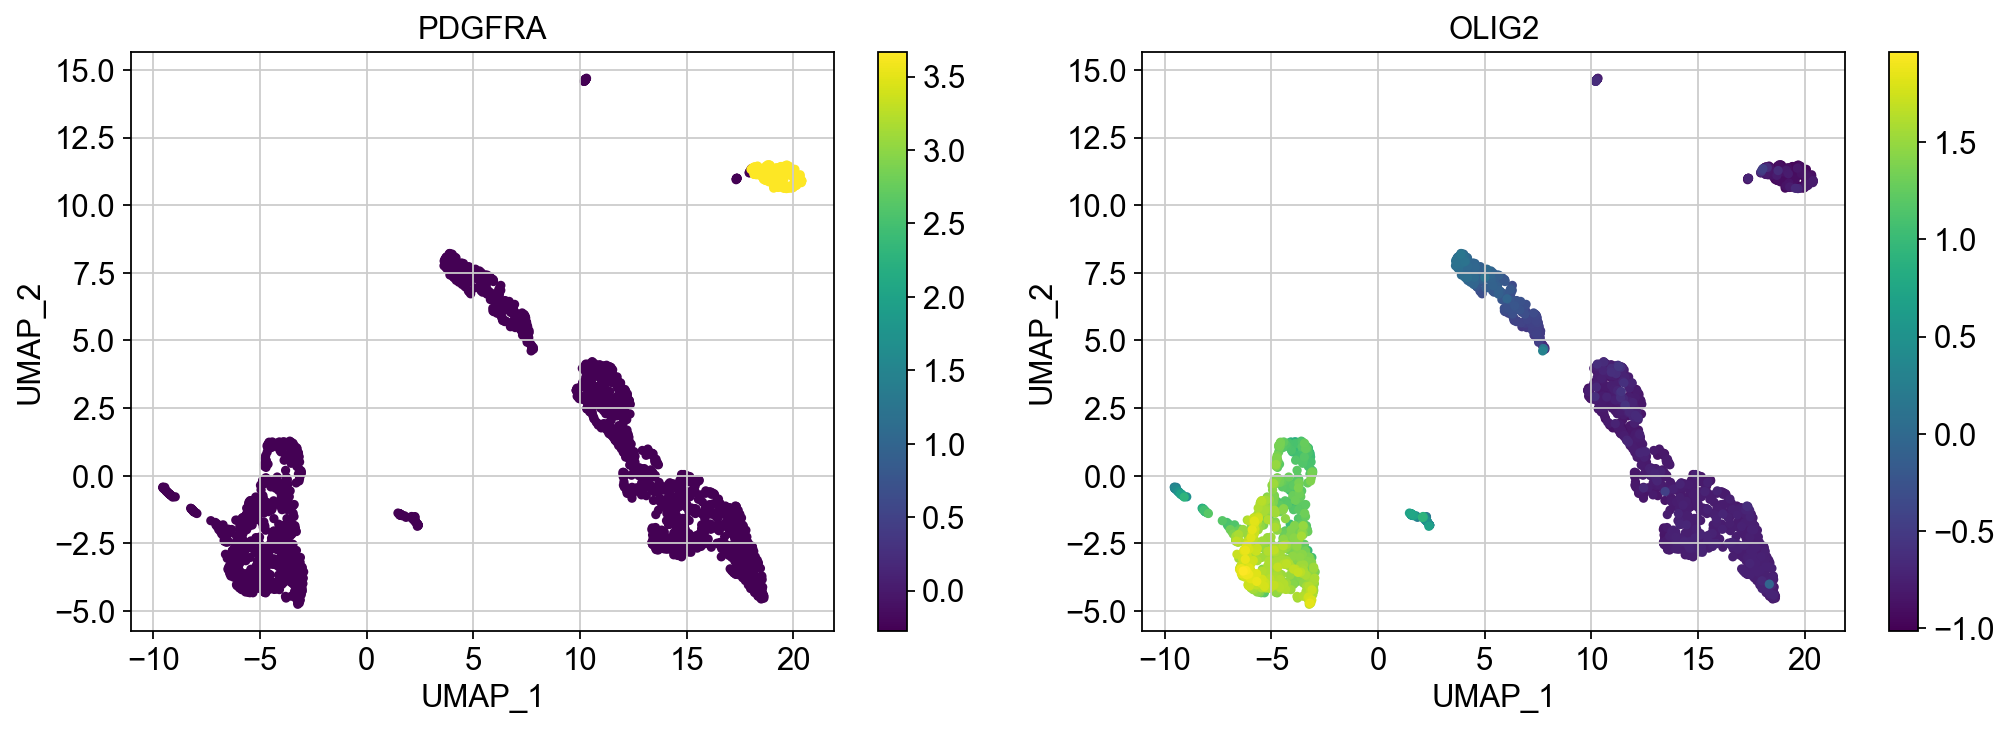

In [96]:
plot_imputed_features(
    cistopic_obj,
    reduction_name='UMAP',
    imputed_data=gene_act,
    features=['PDGFRA', 'OLIG2'], #Glia
    scale=True,
    num_columns=4
)

In [97]:
print("Number of DAGs found:")
print("---------------------")
for x in markers_dict:
    print(f"  {x}: {len(DAG_markers_dict[x])}")

Number of DAGs found:
---------------------
  B_cells_1: 1594
  B_cells_2: 2076
  CD14+_Monocytes: 2512
  CD4_T_cells: 3026
  CD8_T_cells: 910
  Dendritic_cells: 2320
  FCGR3A+_Monocytes: 2036
  NK_cells: 1122


In [98]:
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)